##Bibliotecas

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from google.colab import drive

import tensorflow as tf
import os
from math import sqrt
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model, Model
from keras.layers import Input, LSTM, Dropout, Lambda, concatenate, add
from keras.layers.core import Dense, Activation
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras import backend as K

import pickle


#Conexão com drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/Projeto PIBIC RedesWireless/PIBIC Moises/Notebooks/Treinamento/Dados Treinamento/Rodada50/Dados_para_modelo.csv'
path_validation = '/content/drive/Shareddrives/Projeto PIBIC RedesWireless/PIBIC Moises/Notebooks/Treinamento/Dados Treinamento/Rodada50/Dados_para_modelo_vali.csv'
os.chdir('/content/drive/Shareddrives/Projeto PIBIC RedesWireless/PIBIC Moises/Notebooks/Treinamento/')

Mounted at /content/drive


##Funções utilizadas

In [2]:
class PlotAndSaveTrain(tf.keras.callbacks.Callback):                            # função de callback para a função de treinamento da rede neural que salva os checkpoint e plots
  def __init__(self, lastPlotData, model, showNumber, plotNumber, mng, savePlot): # construtor da função
    self.model = model                                                          # armazena o modelo
    self.showNumber = showNumber                                                # frequência de salvamento dos chekpoint e dos plots em arquivo
    self.manager = mng                                                          # gerenciador de checkpoints
    self.plotNumber = plotNumber                                                # frequência dos plots na tela
    self.savePlot = savePlot                                                    # indica se deseja salvar os plots em arquivo
    if lastPlotData.empty:                                                      # se o dataframe dos dados de plot está vazio inicia todas as variáveis em zero
      self.i = 0                                                                # índice da época em zero
      self.lastEpoch = 0                                                        # última época do arquivo em zero
      self.x = []                                                               # lista vazia do eixo x (épocas) do plot
      self.losses = []                                                          # lista vazia dos valores de erro de treinamento
      self.val_losses = []                                                      # lista vazia dos valores de erro da validação
      self.acc = []                                                             # lista vazia da acurácia de treiamento
      self.val_acc = []                                                         # lista vazia da acurácia de validação
    else:                                                                       # se o dataframe dos dados possui valores
      self.x = lastPlotData['x'].tolist()                                       # adiciona a lista do eixo x todos os valores anteriores registrados em arquivo
      self.i = self.x[-1] + 1                                                   # atribui ao índice o último elemento do eixo x (equivale a última época registrada) + 1 para a próxima época
      self.lastEpoch = self.x[-1] + 1                                           # atribui a última época o último elemento do eixo x (equivale a ultima época registrada)
      self.losses = lastPlotData['losses'].tolist()                             # atribui a lista de erros de treinamento todos os valores de erros de treinamento anteriores
      self.val_losses = lastPlotData['val_losses'].tolist()                     # atribui a lista de erros de validação todos os valores de erros validação anteriores
      self.acc = lastPlotData['acc'].tolist()                                   # atribui a lista de acurácia de treinamento todos os valores de acurácia de treinamento anteriores
      self.val_acc = lastPlotData['val_acc'].tolist()                           # atribui a lista de acuária de validação todos os valores de acurácia de validação anteriores
      
  def on_epoch_end(self, epoch, logs={}):                                       # função executada ao final de cada época
    self.x.append(self.i)                                                       # adiciona a lista do eixo x o valor do indice de execução atual
    self.losses.append(logs.get('loss'))                                        # adiciona a lista do erro de treinamento o erro atual
    self.val_losses.append(logs.get('val_loss'))                                # adiciona a lista do erro de validação o erro atual
    self.acc.append(logs.get('mae'))                                            # adiciona a lista de acurácia de treinamento a acurácia atual
    self.val_acc.append(logs.get('val_mae'))                                    # adiciona a lista de acurácia de validaçãp a acurácia atual
    self.i += 1                                                                 # incrementa o indice de execução atual
    if((epoch + 1) % self.plotNumber == 0):                                     # se a época atual for igual a escolhida para o salvamento
      fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(16,8))  # cria a figura de 2x2 para o plot dos gráficos
      fig.suptitle('Loss and accuracy')                                         # dá o título da figura
      clear_output(wait=True)                                                   # adiciona o comando de limpeza da figura para ser executado quando os dados estiverem disponíveis
      
      windowsSize = 50                                                          # tamanho da janela de zoom
      xWindow = []                                                              # elementos do eixo x da janela de zoom
      lWindow = []                                                              # elementos do erro de treinamento da janela de zoom
      vlWindow = []                                                             # elementos do erro de validação da janela de zoom
      aWindow = []                                                              # elementos da acurácia da janela de zoom
      vaWindow = []                                                             # elementos da acurácia de validação da janela de zoom
      if len(self.x) > windowsSize:                                             # se os valores do plot original forem maiores que a janela
        xStart = len(self.x) - windowsSize                                      # pega os ultimos elementos do plot original na quantidade do tamanho da janela
        xWindow.extend(self.x[xStart:])                                       
        lWindow.extend(self.losses[xStart:])
        vlWindow.extend(self.val_losses[xStart:])
        aWindow.extend(self.acc[xStart:])
        vaWindow.extend(self.val_acc[xStart:])
      else:                                                                     # se os valores do plot original forem menores que a janela
        xWindow.extend(self.x)                                                  # pega todos os elementos do plot original atualmente
        lWindow.extend(self.losses)
        vlWindow.extend(self.val_losses)
        aWindow.extend(self.acc)
        vaWindow.extend(self.val_acc)
      
      ax1.set_yscale('log')                                                     # plota o primeiro gráfico na escala logarítmica (melhor visualização de grandes dados)
      ax1.plot(self.x, self.losses, label = "loss")                             # plota no primeiro gráfico o erro de treinamento
      ax1.plot(self.x, self.val_losses, label = "val_loss")                     # plota no primeiro gráfico o erro de validação
      ax1.axvspan(xWindow[0], xWindow[-1], alpha=0.2, color='red')              # plota a janela de zoom
      (ax1.set_title('Loss: ' + str('{:.2e}'.format(self.losses[-1])) +
                     ' Val_loss: ' + str('{:.2e}'.format(self.val_losses[-1])) +
                     ' Epoch: ' + str(self.lastEpoch + epoch + 1)))             # legenda com os valores atuais de erro, validação e época
      ax1.legend()                                                              # plota a legenda
      
      ax2.plot(self.x, self.acc, label = "accuracy")                            # plota no primeiro gráfico a acurácia do treinamento
      ax2.plot(self.x, self.val_acc, label = "val_accuracy")                    # plota no primeiro gráfico a acurácia da validação
      ax2.axvspan(xWindow[0], xWindow[-1], alpha=0.2, color='red')              # plota a janela de zoom
      (ax2.set_title('Acc: ' + str(self.acc[-1]) +
                     ' Val_acc: ' + str(self.val_acc[-1]) +
                     ' Epoch: ' + str(self.lastEpoch + epoch + 1)))             # legenda com os valores atuais de erro, validação e época
      ax2.legend()                                                              # plota a legenda
      
      ax3.set_yscale('log')                                                     # plota o primeiro gráfico na escala logarítmica (melhor visualização de grandes dados) em zoom
      ax3.plot(xWindow, lWindow, label = "loss")                                # plota no primeiro gráfico o erro de treinamento em zoom
      ax3.plot(xWindow, vlWindow, label = "val_loss")                           # plota no primeiro gráfico o erro de validação em zoom
      (ax3.set_title('Zoom from loss plot. Loss: ' + str('{:.2e}'.format(self.losses[-1])) +
                     ' Val_loss: ' + str('{:.2e}'.format(self.val_losses[-1]))))# legenda com os valores atuais de erro, validação no zoom
      ax3.legend()                                                              # plota a legenda
      
      ax4.plot(xWindow, aWindow, label = "accuracy")                            # plota no primeiro gráfico a acurácia do treinamento em zoom
      ax4.plot(xWindow, vaWindow, label = "val_accuracy")                       # plota no primeiro gráfico a acurácia da validação em zoom
      (ax4.set_title('Zoom from accuracy plot. Acc: ' + str(self.acc[-1]) +
                     ' Val_acc: ' + str(self.val_acc[-1])))                     # legenda com os valores atuais de erro, validação no zoom
      ax4.legend()                                                              # plota a legenda
      
      if self.savePlot:                                                         # se o savePlot for verdadeira
        plt.savefig(plotsDir + '/treinamentoLossAcc.png', format='png')         # salva em arquivo o plot
      plt.show();                                                               # plota os 4 gráficos
      
    if((self.showNumber>0) and ((epoch + 1) % self.showNumber == 0)):           # se o showNumber for mairo que zero
      print('Epoch: ' + str(self.lastEpoch + epoch + 1) + ' saving checkpoint\n') # exibe a epoca atual
      dfPlot = (pd.DataFrame({'x': self.x, 'losses': self.losses,'acc': self.acc,
                              'val_losses': self.val_losses, 'val_acc': self.val_acc})) # cria um dataframe com as informações do plot
      dfPlot.to_csv(plotsDir + '/plotData.csv')                                 # salva o dataframe do plot em arquivo
      self.manager.save()                                                       # salva o checkpoint do estado de treinamento da rede neural

def loadLastEpochTrain(manager, checkpoint, newModel, qtyEpochs):               # funcao que, se solicitado, verifica se ha checkpoints e carrega a ultima epoca de treinamento da rede
  lastPlotData = pd.DataFrame()                                                 # cria um dataframe vazio
  remainingEpochs = qtyEpochs
  if manager.latest_checkpoint and not newModel:                                # se existir um chepoint passado e for setado o carregamento
    print("Restored from {}".format(manager.latest_checkpoint))                 # informa o ultimo setpoint armazenado
    checkpoint.restore(manager.latest_checkpoint)                               # carrega o ultimo setpoint
    if os.path.exists(plotsDir + '/plotData.csv'):
      lastPlotData = pd.read_csv(plotsDir + '/plotData.csv')                    # Lê o csv para um dataframe
      remainingEpochs = remainingEpochs - lastPlotData["x"].iloc[-1] + 1        # le a ultima epoca executada
  else:                                                                         # caso contrario
    print("Initializing a new model.")                                          # apenas mantem o modelo gerado inicialmente (de forma aleatoria)
  return lastPlotData, remainingEpochs

In [3]:
def slice_function(array, pacotes):
    inicial = 0
    primeira_linha = 0
    parada = len(array) - pacotes 
    for x in range(0,len(array)):
      if x == parada:
        break
      else:
        if primeira_linha == 0:
          saida = array[inicial:pacotes]
          primeira_linha = 1
        else:
          saida = np.concatenate((saida, array[inicial:pacotes+inicial]), axis=0)
      inicial = inicial + 1
    return saida

In [4]:
#modelo duas camadas
def modelo_camada_duopla(input_shape, n_lstm_units_input,n_lstm_units_output, dropout_rate, n_dense_units):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model = Sequential()
    
    model.add(LSTM(n_lstm_units_input, input_shape=input_shape, return_sequences=True))
    model.add(Dense(n_dense_units, activation='relu'))
    model.add(LSTM(n_lstm_units_output, return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(n_dense_units))
    
    model.compile(loss = root_mean_squared_error, optimizer = opt, metrics = ['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [5]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

##Tratamento


In [6]:
dados = pd.read_csv(path)
dados.drop(columns=['Unnamed: 0'], inplace = True)
dados.drop(columns=['data'], inplace = True)

inputs = dados.drop(columns=["st_lv1"])
targets = dados.drop(columns=['RSSI_0',	'RSSI_1',	'PDRI_0',	'PDRI_1', 'st_lv1'])

inputs = inputs.iloc[:,:5].values
targets = targets.iloc[:].values


In [7]:
periodos = 15 #espaço de previsão para 1 minuto
previsao_futura = 1 #Quantas previsões serão feitasa


In [8]:
#Dados de Treinamento
X = slice_function(inputs, periodos)
X
X_train = X.reshape(-1, periodos, 5)

y = slice_function(targets, periodos)
y_train = y.reshape(-1, periodos, 1)

In [9]:
dados = pd.read_csv(path_validation)
dados.drop(columns=['Unnamed: 0'], inplace = True)
dados.drop(columns=['data'], inplace = True)

inputs = dados.drop(columns=["st_lv1"])
targets = dados.drop(columns=['RSSI_0',	'RSSI_1',	'PDRI_0',	'PDRI_1', 'st_lv1'])

inputs = inputs.iloc[:,:5].values
targets = targets.iloc[:].values


In [10]:
y_train.shape

(7620, 15, 1)

In [11]:
#Dados de Treinamento
X = slice_function(inputs, periodos)
X
X_vali = X.reshape(-1, periodos, 5)

y = slice_function(targets, periodos)
y_vali = y.reshape(-1, periodos, 1)

In [12]:
y_vali.shape
validationData = (X_vali, y_vali)

##Treinamento dos modelos

###Modelo 15x5 Neurônios



In [18]:
modelName = 'Modelo 15x5 neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

In [19]:
entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 5
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model1 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)



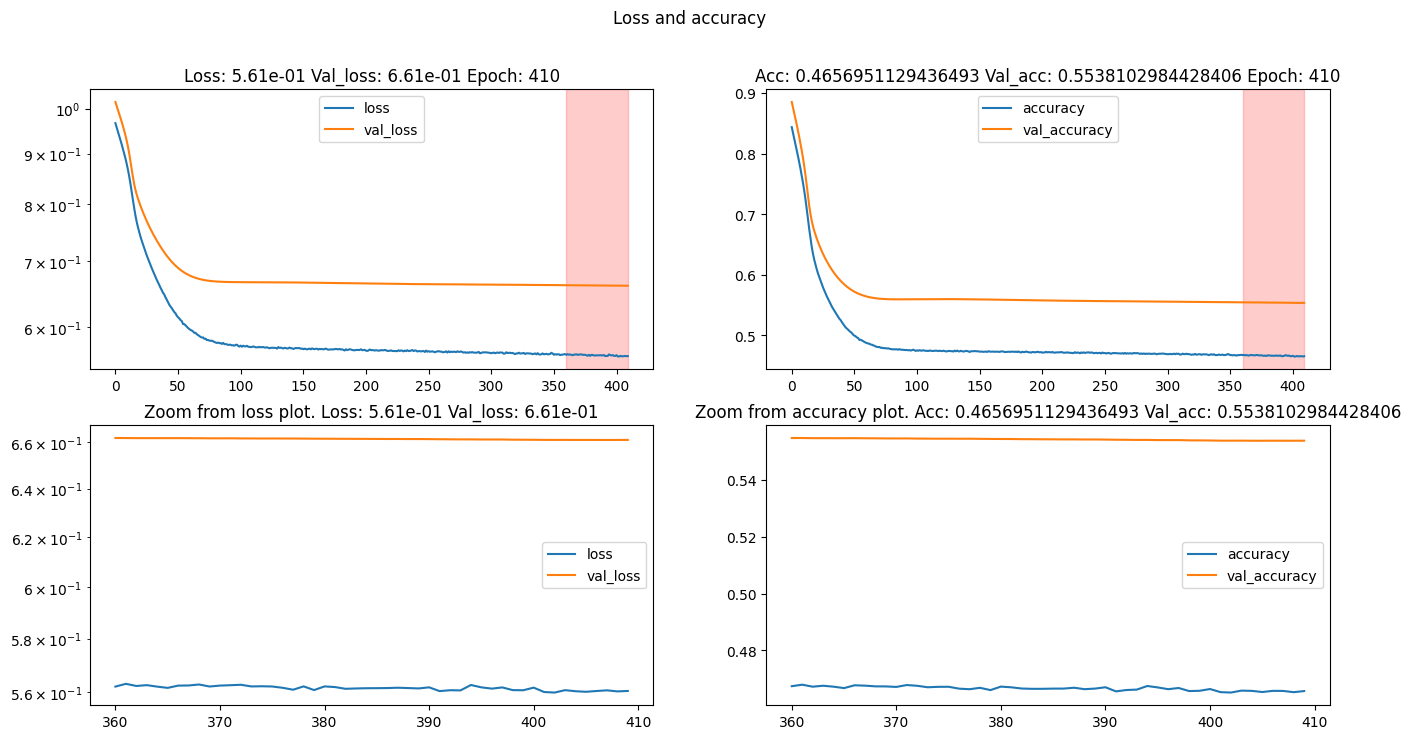

In [20]:
checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model1)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model1, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)




In [21]:

modelName = 'Modelo 15x5 neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 

with open(dir + 'Modelo 15x5 neurônios.pkl', 'wb') as file:
    pickle.dump(model1, file)
                                  


###Modelo 15x10 Neurônios

In [22]:
modelName = 'Modelo 15x10 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

In [23]:
entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 10
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model2 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)



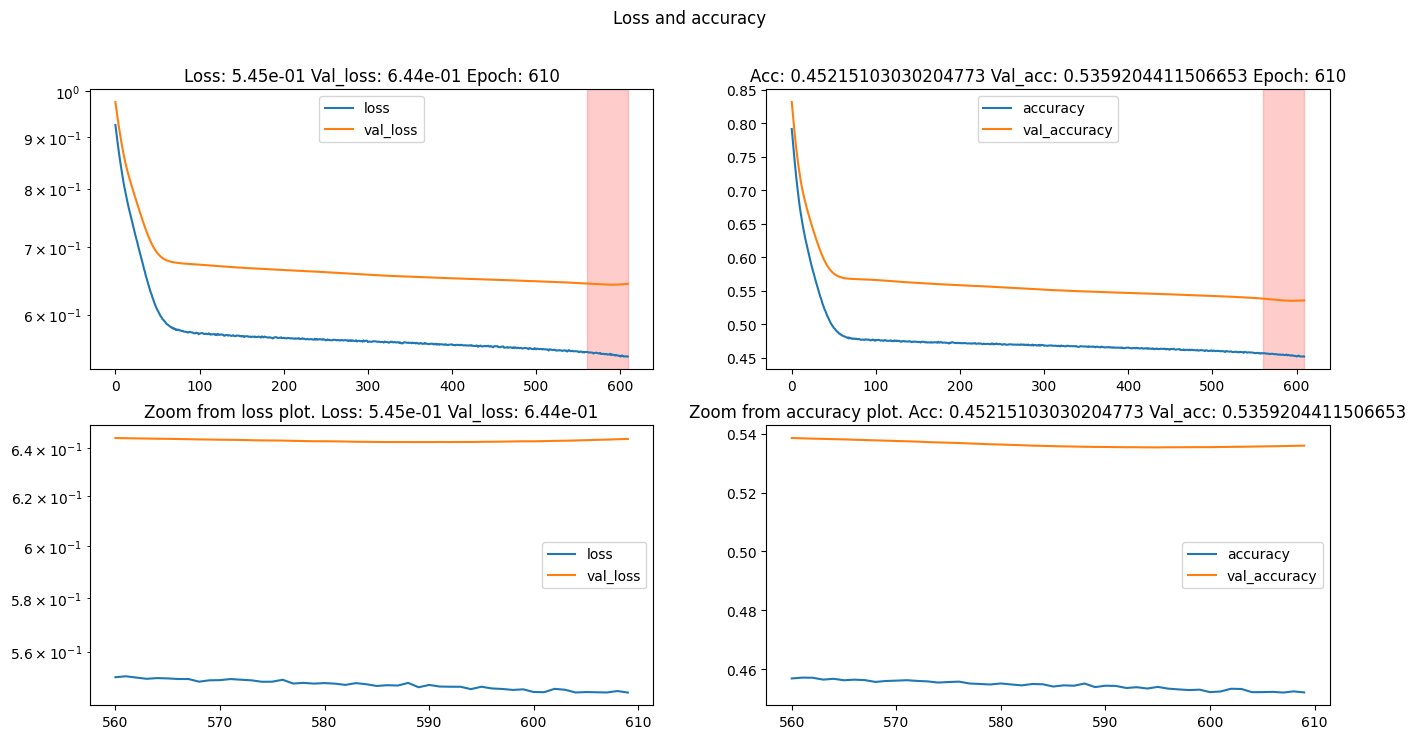

In [24]:
checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model2)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history2 = model2.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model2, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)


In [25]:
modelName = 'Modelo 15x10 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 15x10 Neurônios.pkl', 'wb') as file:
    pickle.dump(model2, file)
                                  


###Modelo 15x20 Neurônios

In [26]:
modelName = 'Modelo 15x20 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model3 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)



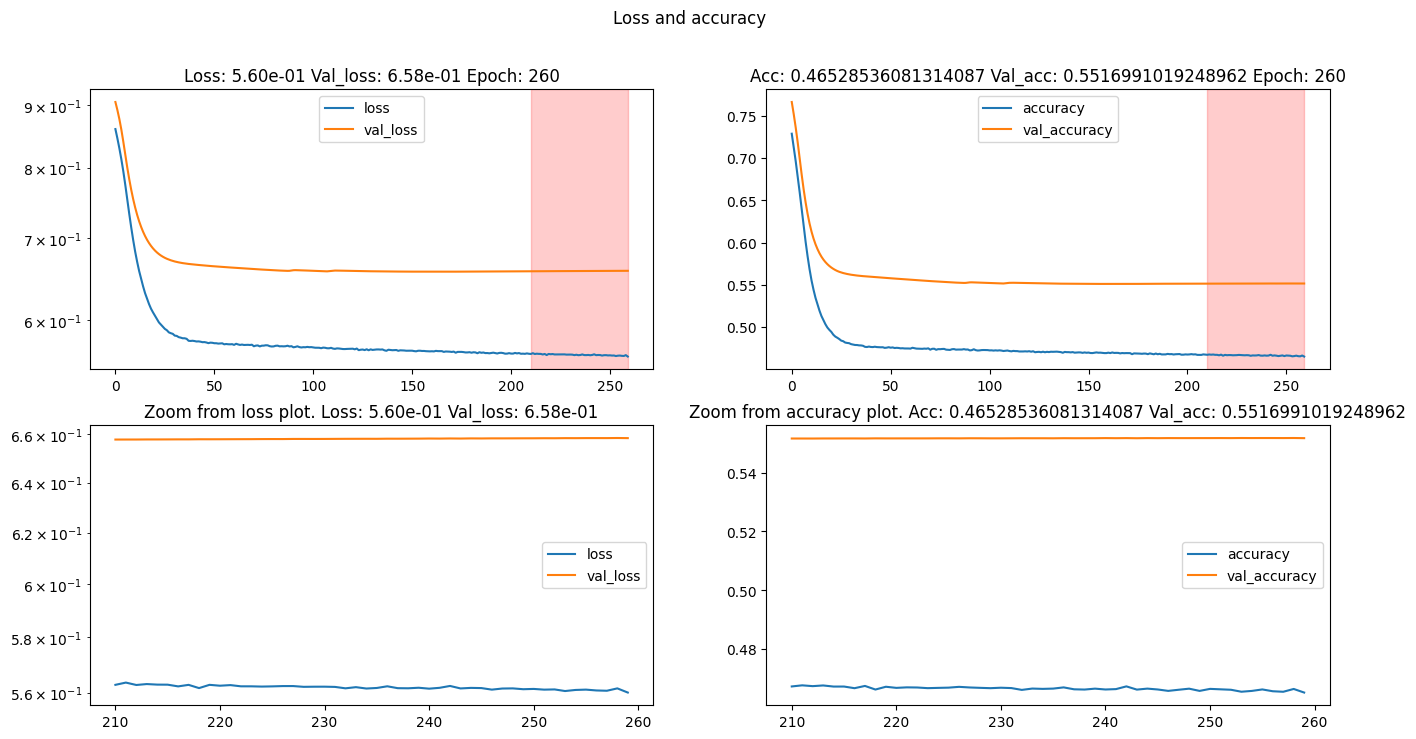

In [27]:
checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model3)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history3 = model3.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model3, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)


In [28]:
modelName = 'Modelo 15x20 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 15x20 Neurônios.pkl', 'wb') as file:
    pickle.dump(model3, file)
                                  


###Modelo 20x5 Neurônios

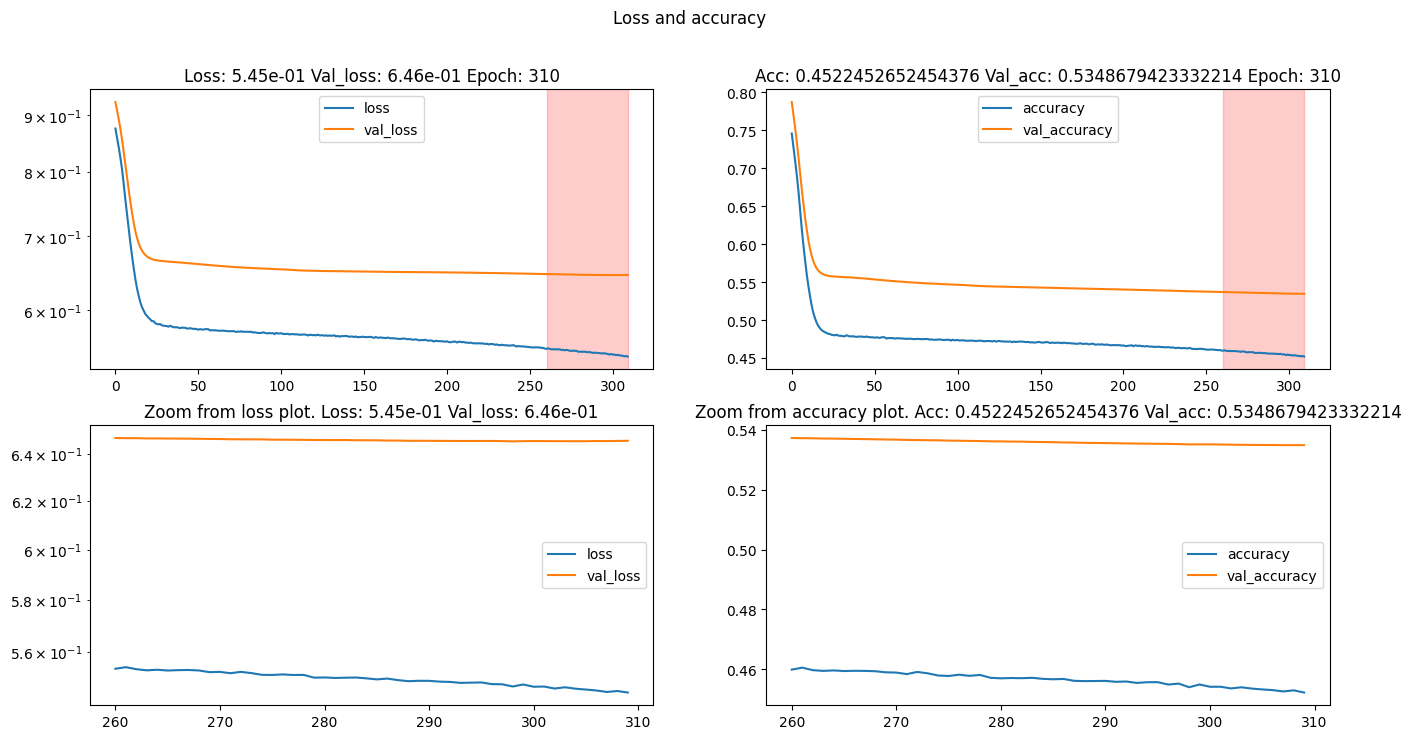

In [29]:
modelName = 'Modelo 20x5 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model4 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6), model = model4)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history4 = model4.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model4, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)


In [30]:
modelName = 'Modelo 20x5 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 20x5 Neurônios.pkl', 'wb') as file:
    pickle.dump(model4, file)
                                  


###Modelo 20x10 Neurônios

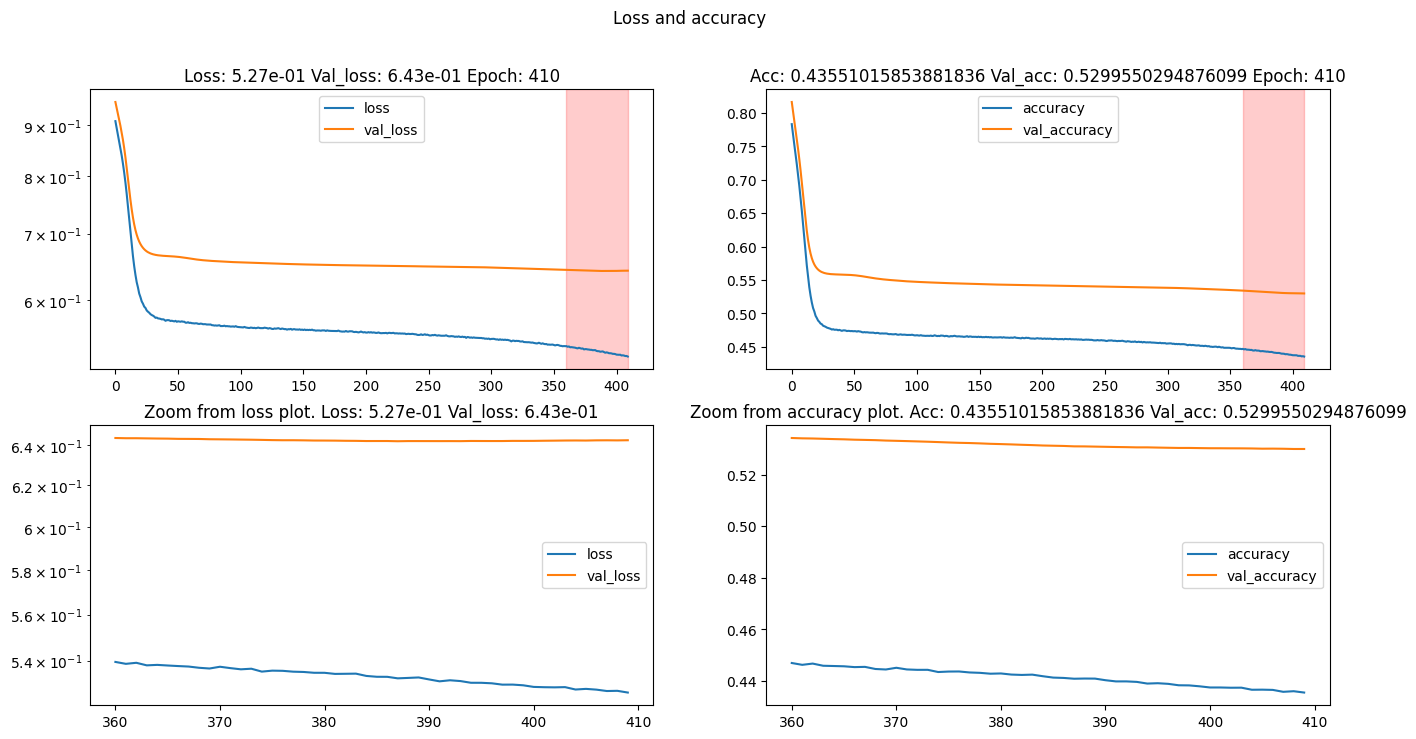

In [31]:
modelName = 'Modelo 20x10 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model5 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model5)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history5 = model5.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model5, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)


In [32]:
modelName = 'Modelo 20x10 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 20x10 Neurônios.pkl', 'wb') as file:
    pickle.dump(model5, file)
                                  


###Modelo 20x15 Neurônios

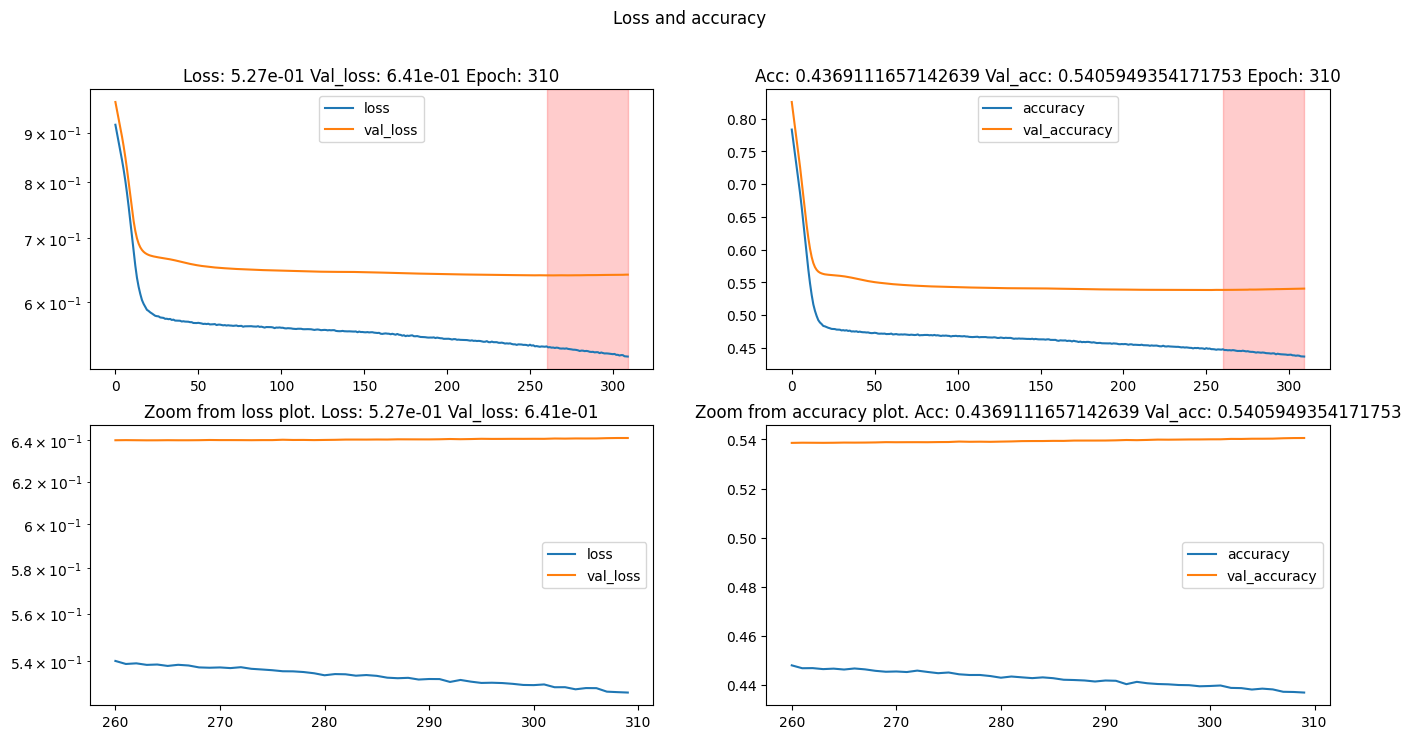

In [33]:
modelName = 'Modelo 20x15 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 15
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model6 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), model = model6)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history6 = model6.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model6, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)


In [34]:
modelName = 'Modelo 20x15 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 20x15 Neurônios.pkl', 'wb') as file:
    pickle.dump(model6, file)
                                  


###Modelo 5x15 Neurônios

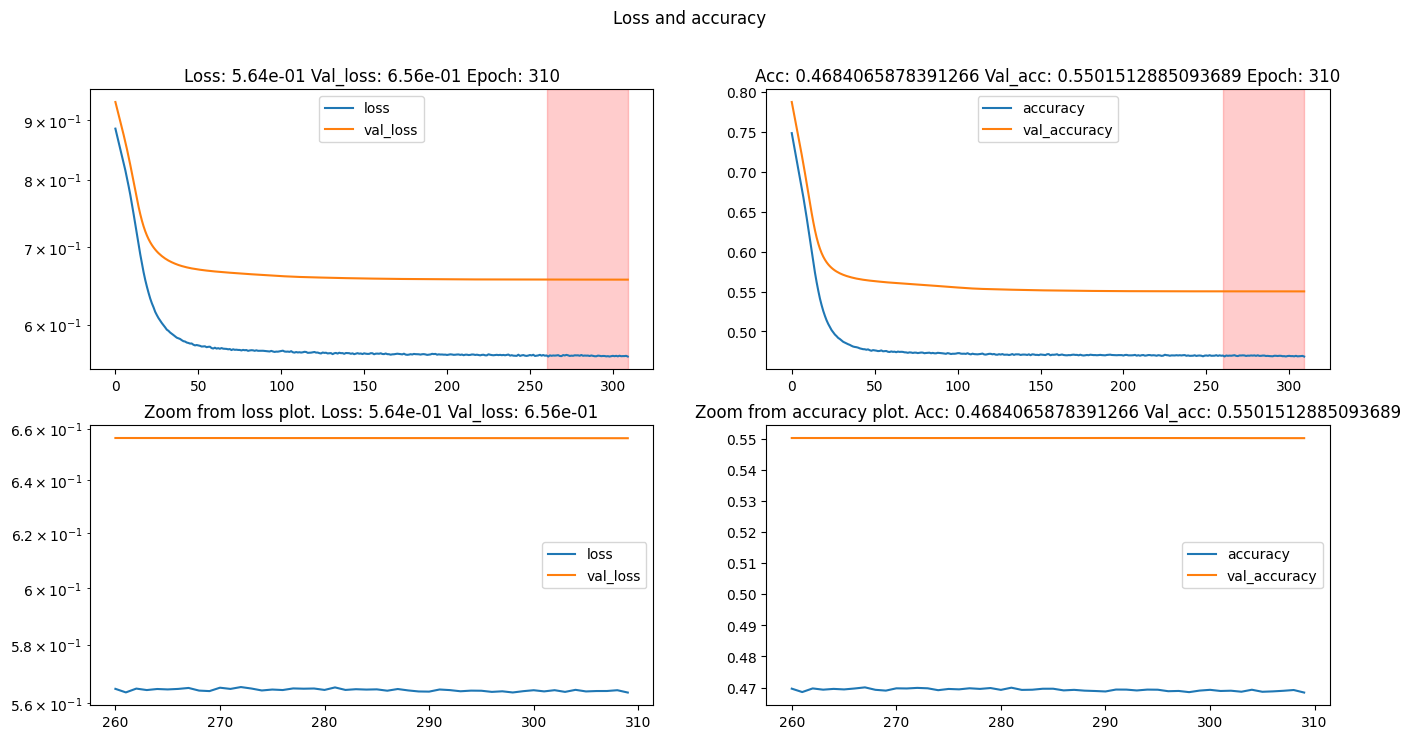

In [35]:
modelName = 'Modelo 5x15 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 5
camada_oculta_saida = 15
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model7 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model7)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history7 = model7.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model7, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)

modelName = 'Modelo 5x15 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 5x15 Neurônios.pkl', 'wb') as file:
    pickle.dump(model7, file)
                             


###Modelo 10x15 Neurônios

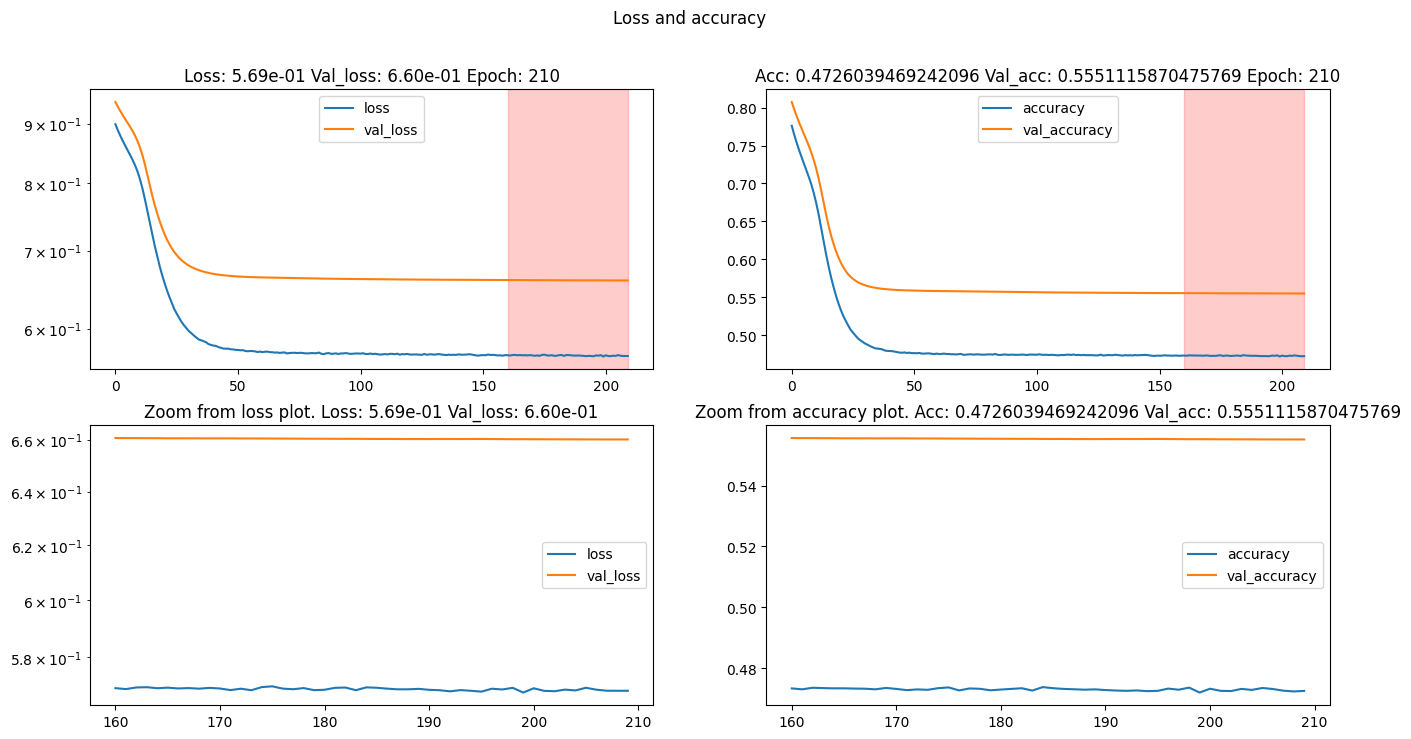

In [36]:
modelName = 'Modelo 10x15 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 10
camada_oculta_saida = 15
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model8 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model8)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history8 = model8.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model8, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)

modelName = 'Modelo 10x15 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 10x15 Neurônios.pkl', 'wb') as file:
    pickle.dump(model8, file)
                             


###Modelo 5x20 Neurônios

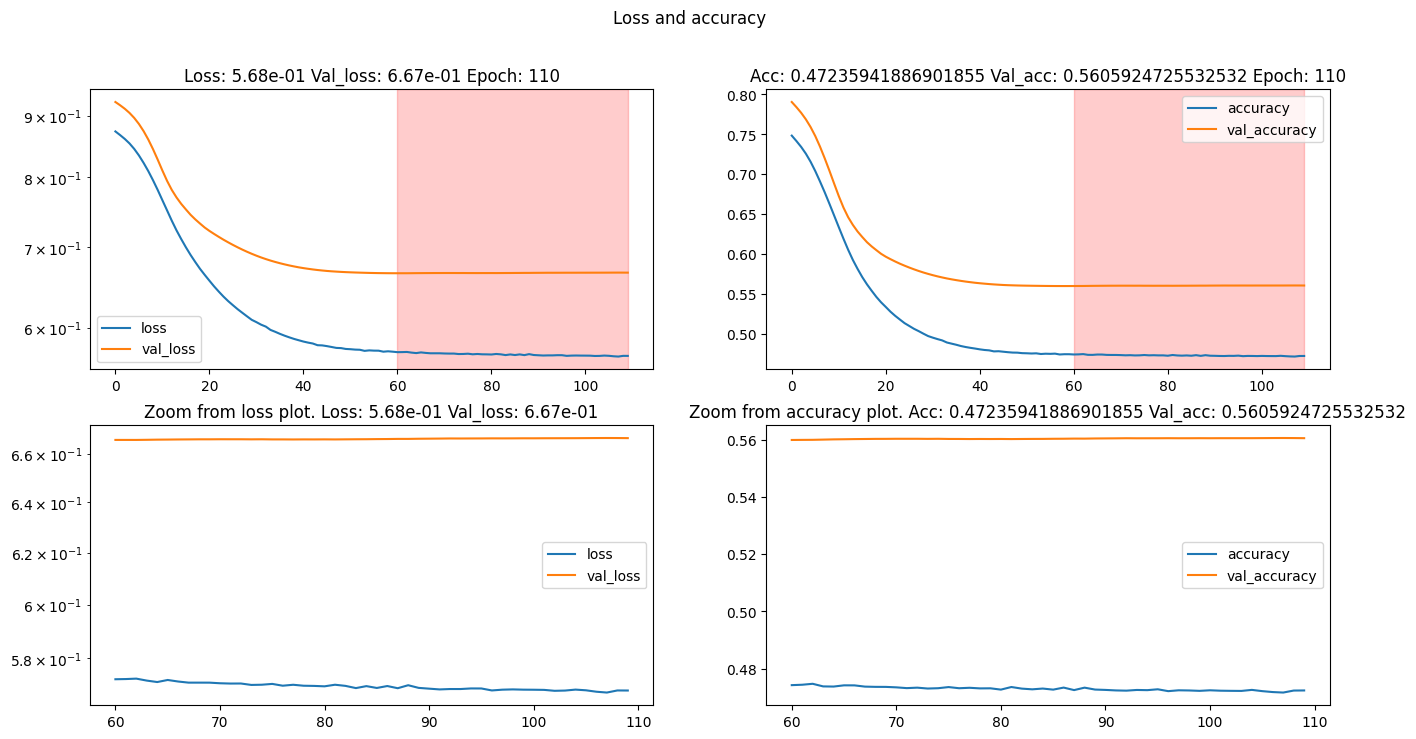

In [37]:
modelName = 'Modelo 5x20 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 5
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model9 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model9)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history9 = model9.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model9, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)

modelName = 'Modelo 5x20 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 5x20 Neurônios.pkl', 'wb') as file:
    pickle.dump(model9, file)
                             


###Modelo 10x20 Neurônios

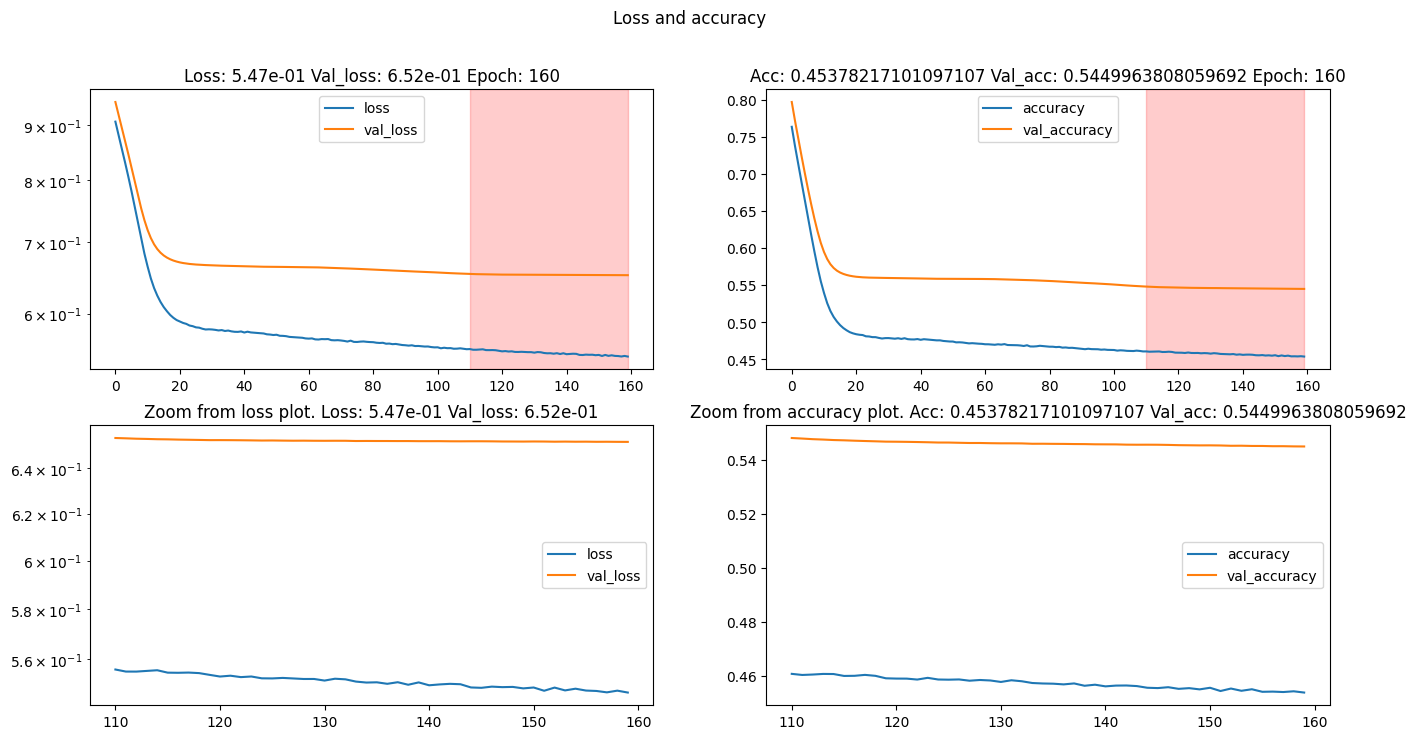

In [38]:
modelName = 'Modelo 10x20 Neurônios'                                    # nome da pasta para a rede neural em treinamento
if not os.path.isdir('Models/' + modelName):                                    # verifica se a pasta já existe
  os.makedirs('Models/' + modelName + '/TrainingCheckpointsData')               # se não a cria e cria a subpasta para os chekpoints
  os.makedirs('Models/' + modelName + '/Plots')                                 # cria a subpasta para os chekpoints
checkpoint_dir = 'Models/' + modelName + '/TrainingCheckpointsData'             # nome do diretorio dos chepoints e seu caminho
plotsDir = 'Models/' + modelName + '/Plots' 

entradas = 5
camada_oculta_entrada = 10
camada_oculta_saida = 20
saidas = 1
epochs = 10

# Define the input shape and hyperparameters
input_shape = (periodos, entradas)
dropout_rate = 0.05
n_dslots = 15

# Create the model
model10 = modelo_camada_duopla(input_shape, camada_oculta_entrada,camada_oculta_saida, dropout_rate, n_dslots)

checkpoint = tf.train.Checkpoint(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), model = model10)                # cria um checkpoint que salva o otimizador e os pesos do modelo
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep = 1)

lastPlotData, remainingEpochs = loadLastEpochTrain(manager, checkpoint, False, epochs)

history10 = model10.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                    callbacks=[PlotAndSaveTrain(lastPlotData, model10, 50, 5, manager, True)],
                     verbose=0, shuffle=False, validation_data = validationData)

modelName = 'Modelo 10x20 Neurônios'                                    
if not os.path.isdir('Modelos Treinados/' + modelName + '/'):                                      
  os.makedirs('Modelos Treinados/' + modelName + '/')   
            
dir = 'Modelos Treinados/' + modelName +'/'          
 
with open(dir + 'Modelo 10x20 Neurônios.pkl', 'wb') as file:
    pickle.dump(model10, file)
                             


##Validação dos modelos

In [39]:
dados = pd.read_csv(path_validation)
dados.drop(columns=['Unnamed: 0'], inplace = True)
dados.drop(columns=['data'], inplace = True)

inputs = dados.drop(columns=["st_lv1"])
targets = dados.drop(columns=['RSSI_0',	'RSSI_1',	'PDRI_0',	'PDRI_1', 'st_lv1'])

inputs = inputs.iloc[:,:5].values
targets = targets.iloc[:].values

periodos = 15 #espaço de previsão para 1 minuto
previsao_futura = 1 #Quantas previsões serão feitas

X = slice_function(inputs, periodos)
X
X_test = X.reshape(-1, periodos, 5)

y = slice_function(targets,periodos)
y_test = y.reshape(-1, periodos, 1)


paths = [
         'Modelos Treinados/Modelo 15x5 neurônios/Modelo 15x5 neurônios.pkl',
         'Modelos Treinados/Modelo 15x10 Neurônios/Modelo 15x10 Neurônios.pkl',
         'Modelos Treinados/Modelo 15x20 Neurônios/Modelo 15x20 Neurônios.pkl',
         'Modelos Treinados/Modelo 20x5 Neurônios/Modelo 20x5 Neurônios.pkl',
         'Modelos Treinados/Modelo 20x10 Neurônios/Modelo 20x10 Neurônios.pkl',
         'Modelos Treinados/Modelo 20x15 Neurônios/Modelo 20x15 Neurônios.pkl',
         'Modelos Treinados/Modelo 5x15 Neurônios/Modelo 5x15 Neurônios.pkl',
         'Modelos Treinados/Modelo 10x15 Neurônios/Modelo 10x15 Neurônios.pkl',
         'Modelos Treinados/Modelo 5x20 Neurônios/Modelo 5x20 Neurônios.pkl',
         'Modelos Treinados/Modelo 10x20 Neurônios/Modelo 10x20 Neurônios.pkl'
         

         

         
]

with open(paths[0], 'rb') as arquivo:
    modelos1 = pickle.load(arquivo)
with open(paths[1], 'rb') as arquivo:
    modelos2 = pickle.load(arquivo)
with open(paths[2], 'rb') as arquivo:
    modelos3 = pickle.load(arquivo)
with open(paths[3], 'rb') as arquivo:
    modelos4 = pickle.load(arquivo)
with open(paths[4], 'rb') as arquivo:
    modelos5 = pickle.load(arquivo)
with open(paths[5], 'rb') as arquivo:
    modelos6 = pickle.load(arquivo)
with open(paths[6], 'rb') as arquivo:
    modelos7 = pickle.load(arquivo)
with open(paths[7], 'rb') as arquivo:
    modelos8 = pickle.load(arquivo)
with open(paths[8], 'rb') as arquivo:
    modelos9 = pickle.load(arquivo)
with open(paths[9], 'rb') as arquivo:
    modelos10 = pickle.load(arquivo)



##Comportamento dos modelos com dados de treinamento

In [41]:

target_train1 = modelos1.predict(X_train)
target_train2 = modelos2.predict(X_train)
target_train3 = modelos3.predict(X_train)
target_train4 = modelos4.predict(X_train)
target_train5 = modelos5.predict(X_train)
target_train6 = modelos6.predict(X_train)
target_train7 = modelos7.predict(X_train)
target_train8 = modelos8.predict(X_train)
target_train9 = modelos9.predict(X_train)
target_train10 = modelos10.predict(X_train)



mse_Func = tf.keras.losses.MeanSquaredError()
rmse_func = tf.keras.metrics.RootMeanSquaredError()
mae_func = tf.keras.losses.MeanAbsoluteError()

mae  =  mae_func(y_train[:,0], target_train1[:,0]).numpy()
mse  =  mse_Func(y_train[:,0], target_train1[:,0]).numpy()
rmse =  rmse_func(y_train[:,0], target_train1[:,0]).numpy()


print('Modelo 1 MAE ' + str(mae))
print('modelo 1 MSE ' + str(mse))
print('Modelo 1 RMSE ' + str(rmse))

print('['+'='*30+']')
'''
mae  =  mae_func(y_train[:,0], target_train2[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train2[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train2[:,0]).numpy()

print('Modelo 2 MAE ' + str(mae))
print('modelo 2 MSE ' + str(mse))
print('Modelo 2 RMSE ' + str(rmse))
print('['+'='*30+']')
'''
mae  =  mae_func(y_train[:,0], target_train3[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train3[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train3[:,0]).numpy()

print('Modelo 3 MAE ' + str(mae))
print('modelo 3 MSE ' + str(mse))
print('Modelo 3 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train4[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train4[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train4[:,0]).numpy()

print('Modelo 4 MAE ' + str(mae))
print('modelo 4 MSE ' + str(mse))
print('Modelo 4 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train5[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train5[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train5[:,0]).numpy()

print('Modelo 5 MAE ' + str(mae))
print('modelo 5 MSE ' + str(mse))
print('Modelo 5 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train6[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train6[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train6[:,0]).numpy()

print('Modelo 6 MAE ' + str(mae))
print('modelo 6 MSE ' + str(mse))
print('Modelo 6 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train7[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train7[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train7[:,0]).numpy()

print('Modelo 7 MAE ' + str(mae))
print('modelo 7 MSE ' + str(mse))
print('Modelo 7 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train8[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train8[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train8[:,0]).numpy()

print('Modelo 8 MAE ' + str(mae))
print('modelo 8 MSE ' + str(mse))
print('Modelo 8 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train9[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train9[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train9[:,0]).numpy()

print('Modelo 9 MAE ' + str(mae))
print('modelo 9 MSE ' + str(mse))
print('Modelo 9 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_train[:,0], target_train10[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train10[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train10[:,0]).numpy()

print('Modelo 10 MAE ' + str(mae))
print('modelo 10 MSE ' + str(mse))
print('Modelo 10 RMSE ' + str(rmse))
print('['+'='*30+']')





239/239 [==============================] - 1s 3ms/step
Modelo 1 MAE 0.47662202
modelo 1 MSE 0.5814808
Modelo 1 RMSE 0.75092655
[==============================]
Modelo 3 MAE 0.4772979
modelo 3 MSE 0.5792856
Modelo 3 RMSE 0.7447178
[==============================]
Modelo 4 MAE 0.48432085
modelo 4 MSE 0.5865744
Modelo 4 RMSE 0.737092
[==============================]
Modelo 5 MAE 0.49672925
modelo 5 MSE 0.6053892
Modelo 5 RMSE 0.72675127
[==============================]
Modelo 6 MAE 0.487472
modelo 6 MSE 0.5845101
Modelo 6 RMSE 0.72427446
[==============================]
Modelo 7 MAE 0.4771215
modelo 7 MSE 0.5807827
Modelo 7 RMSE 0.7282608
[==============================]
Modelo 8 MAE 0.47432607
modelo 8 MSE 0.57695776
Modelo 8 RMSE 0.73129255
[==============================]
Modelo 9 MAE 0.47518498
modelo 9 MSE 0.57943505
Modelo 9 RMSE 0.73397887
[==============================]
Modelo 10 MAE 0.48635343
modelo 10 MSE 0.5813133
Modelo 10 RMSE 0.7328375
[==============================]


Text(0, 0.5, 'erro (%)')

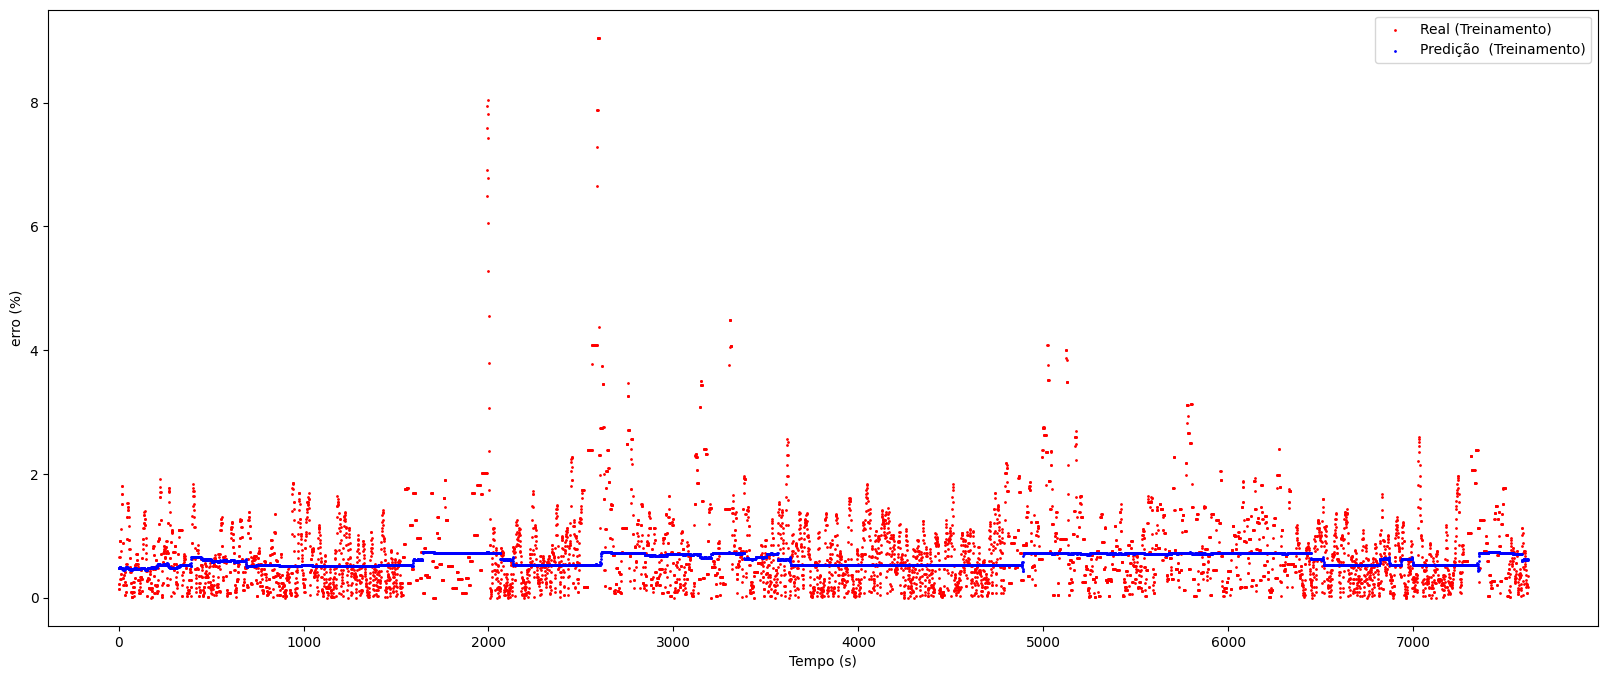

In [42]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train1[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

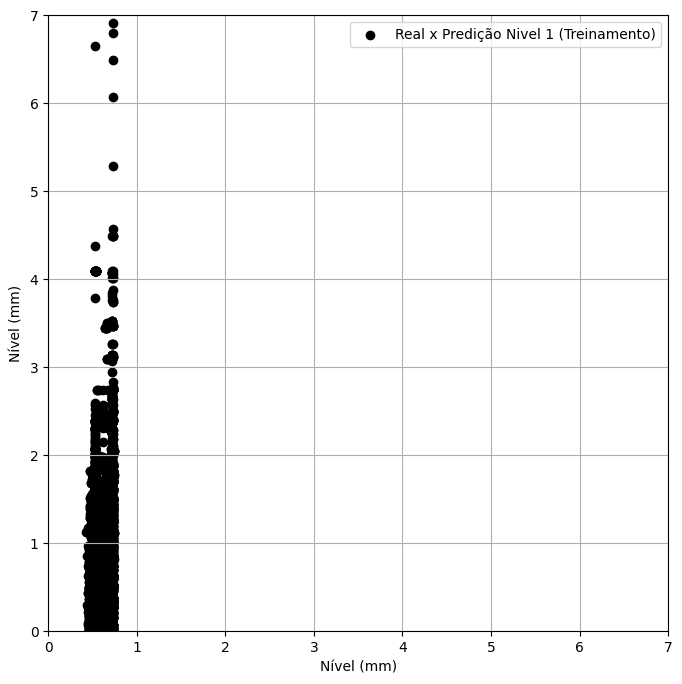

In [43]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

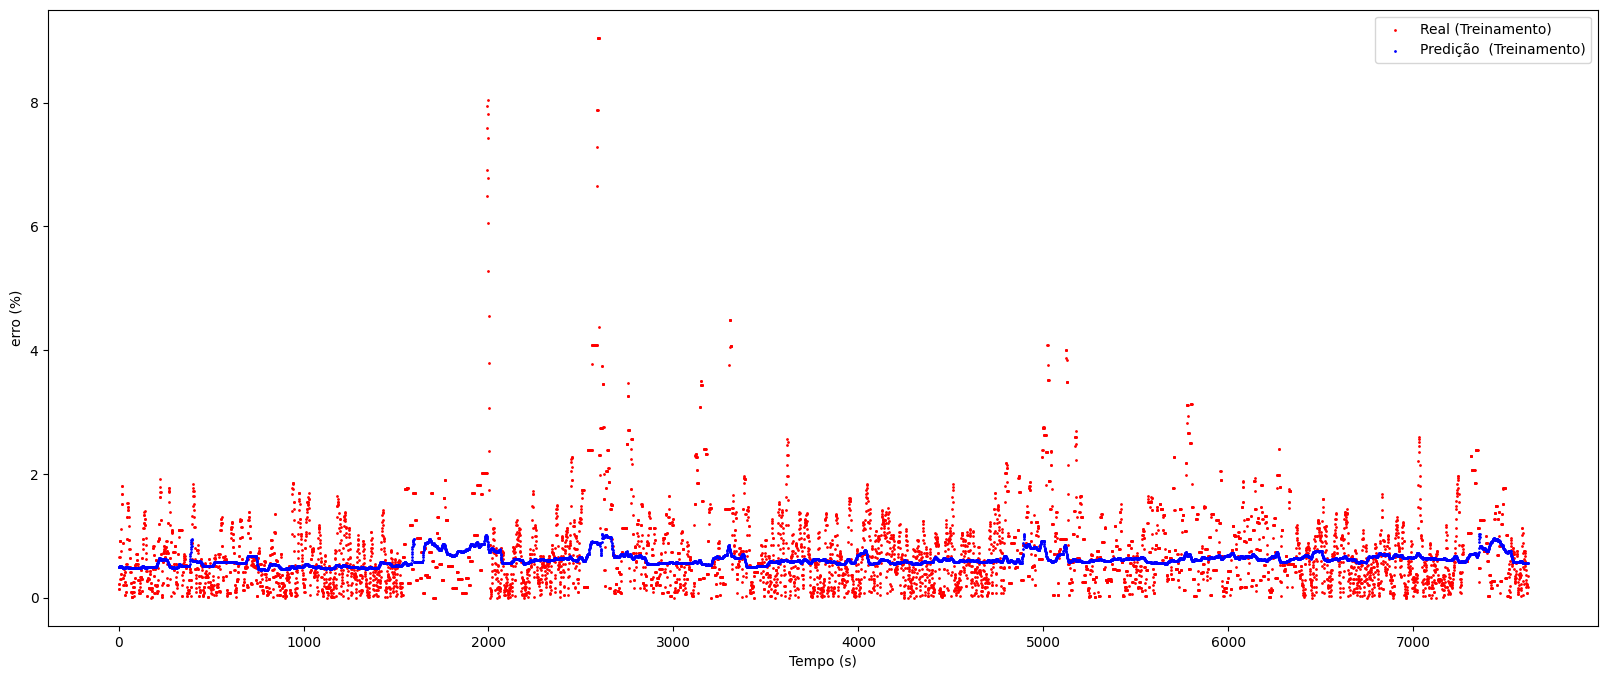

In [44]:
##Modelo 2

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train2[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

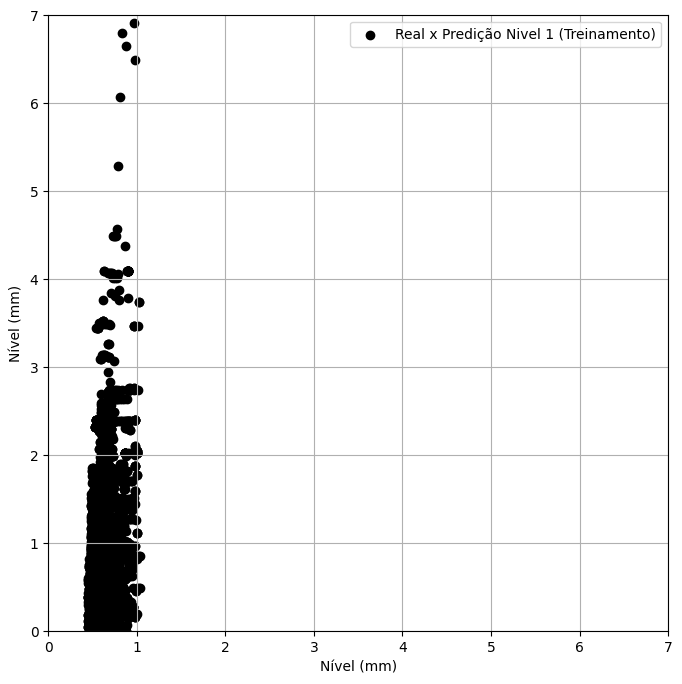

In [45]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

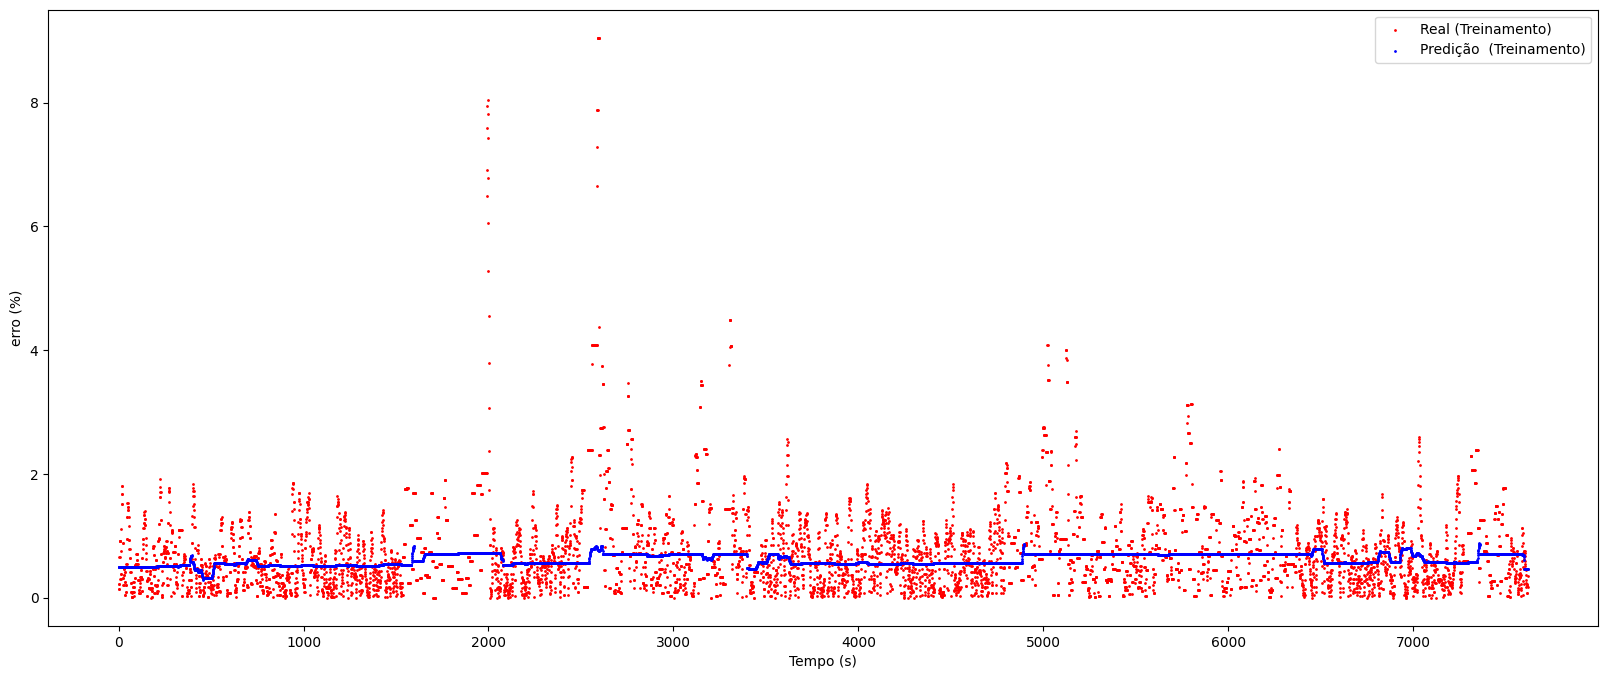

In [46]:
##Modelo 3

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train3[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

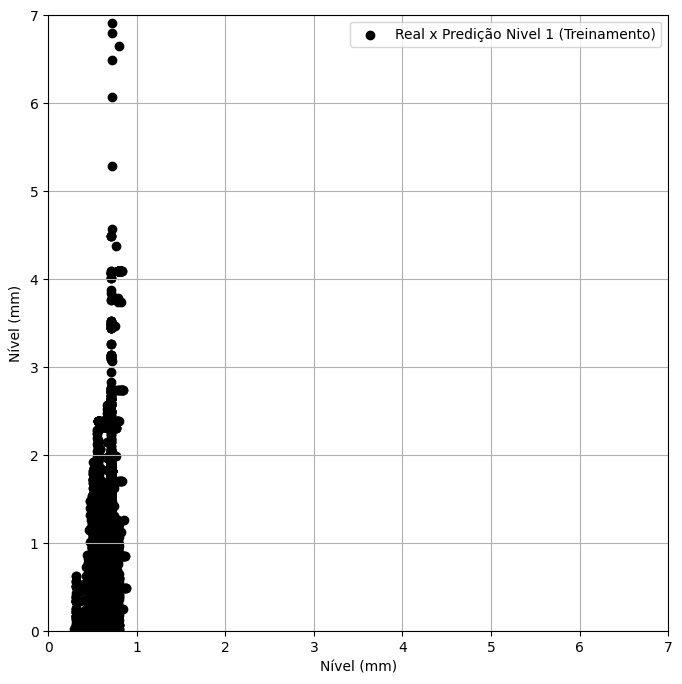

In [47]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

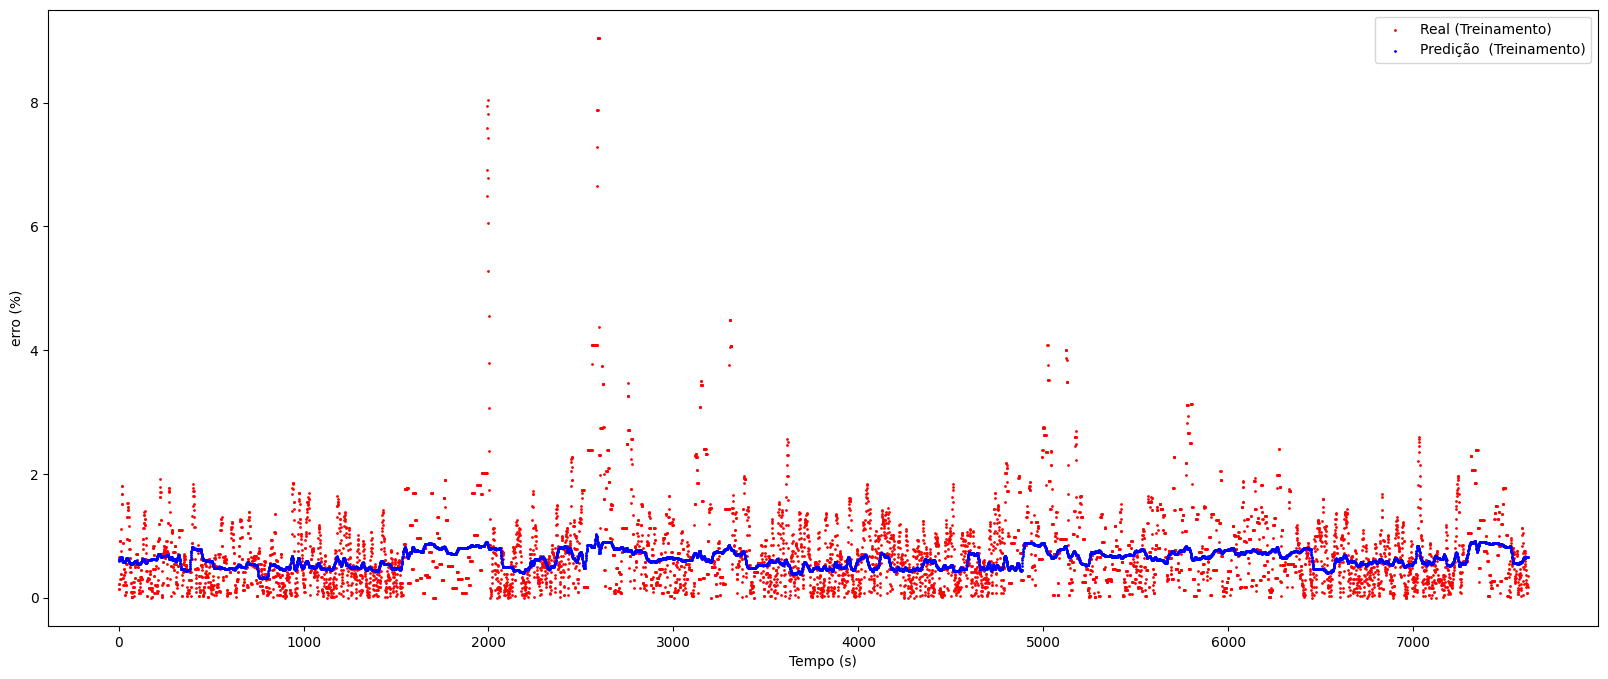

In [48]:
##Modelo 4

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train4[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

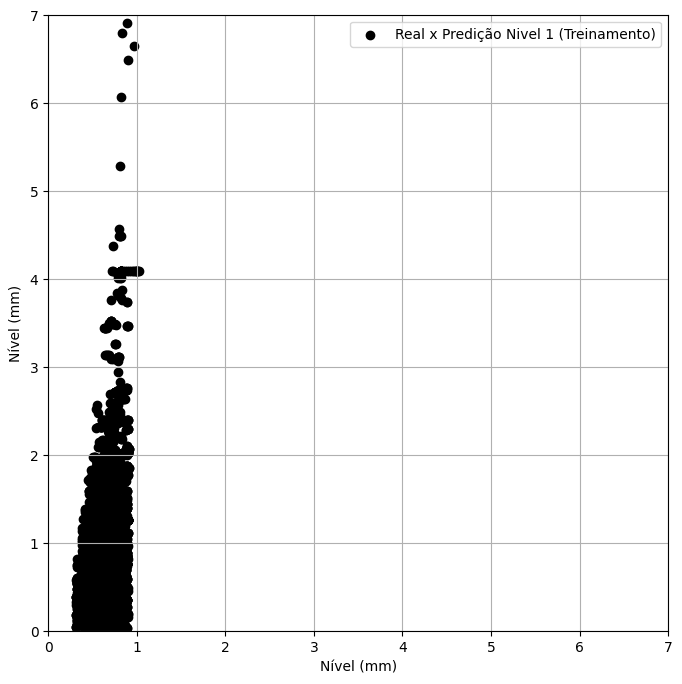

In [49]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

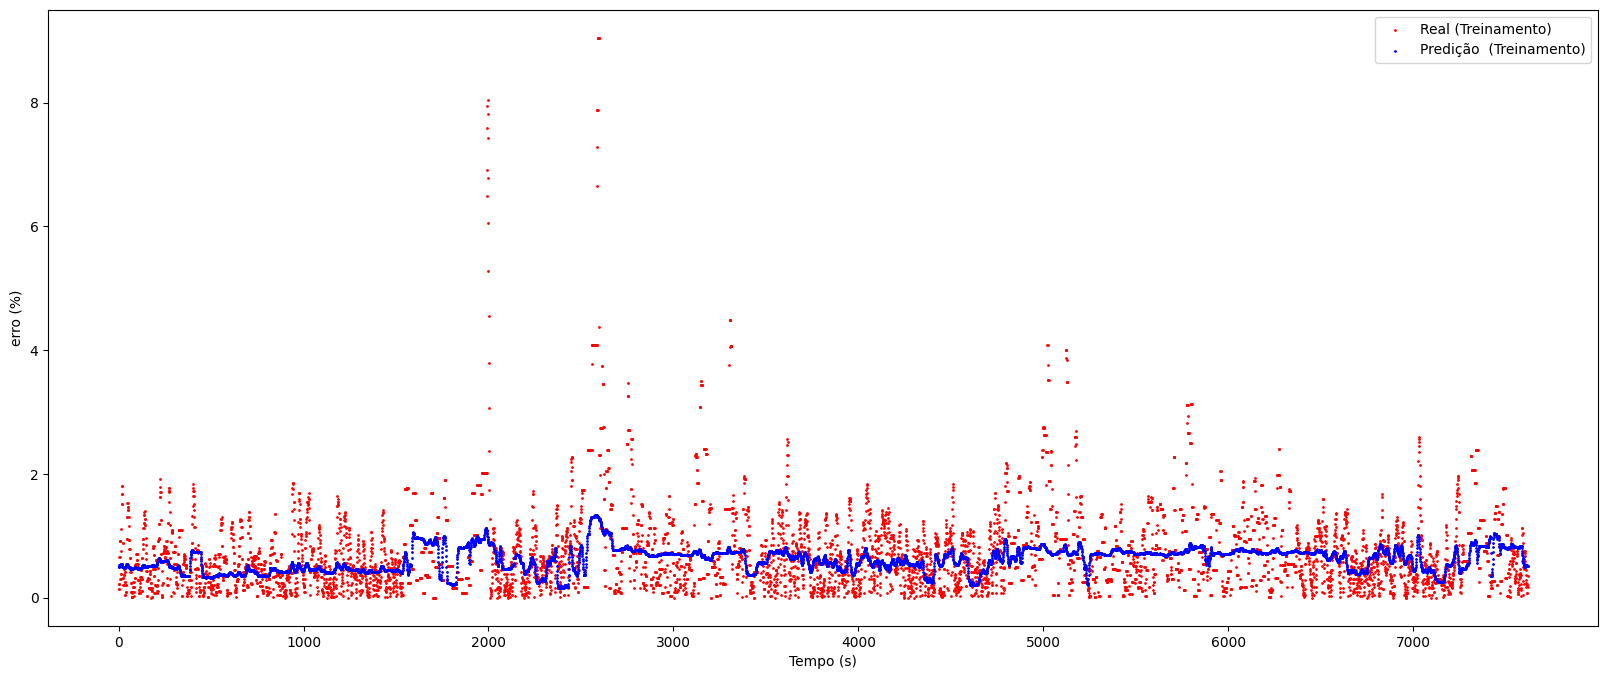

In [50]:
##Modelo 5

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train5[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

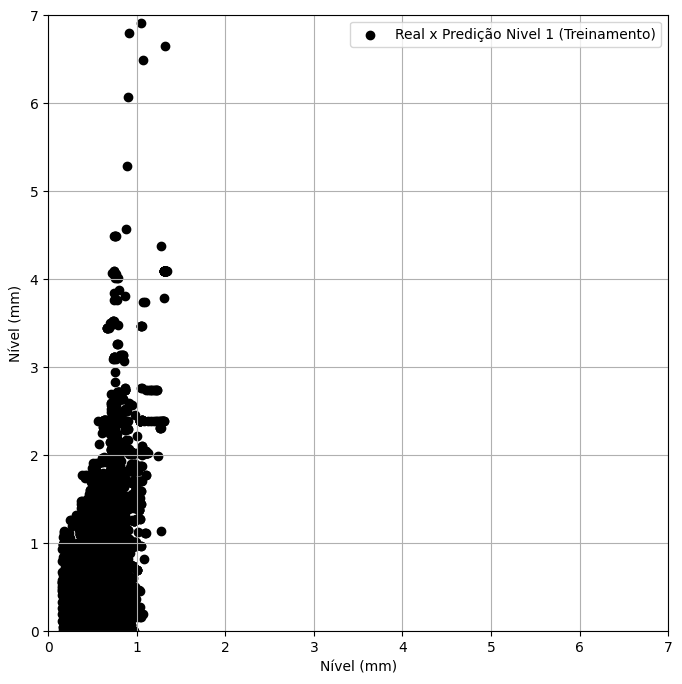

In [51]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

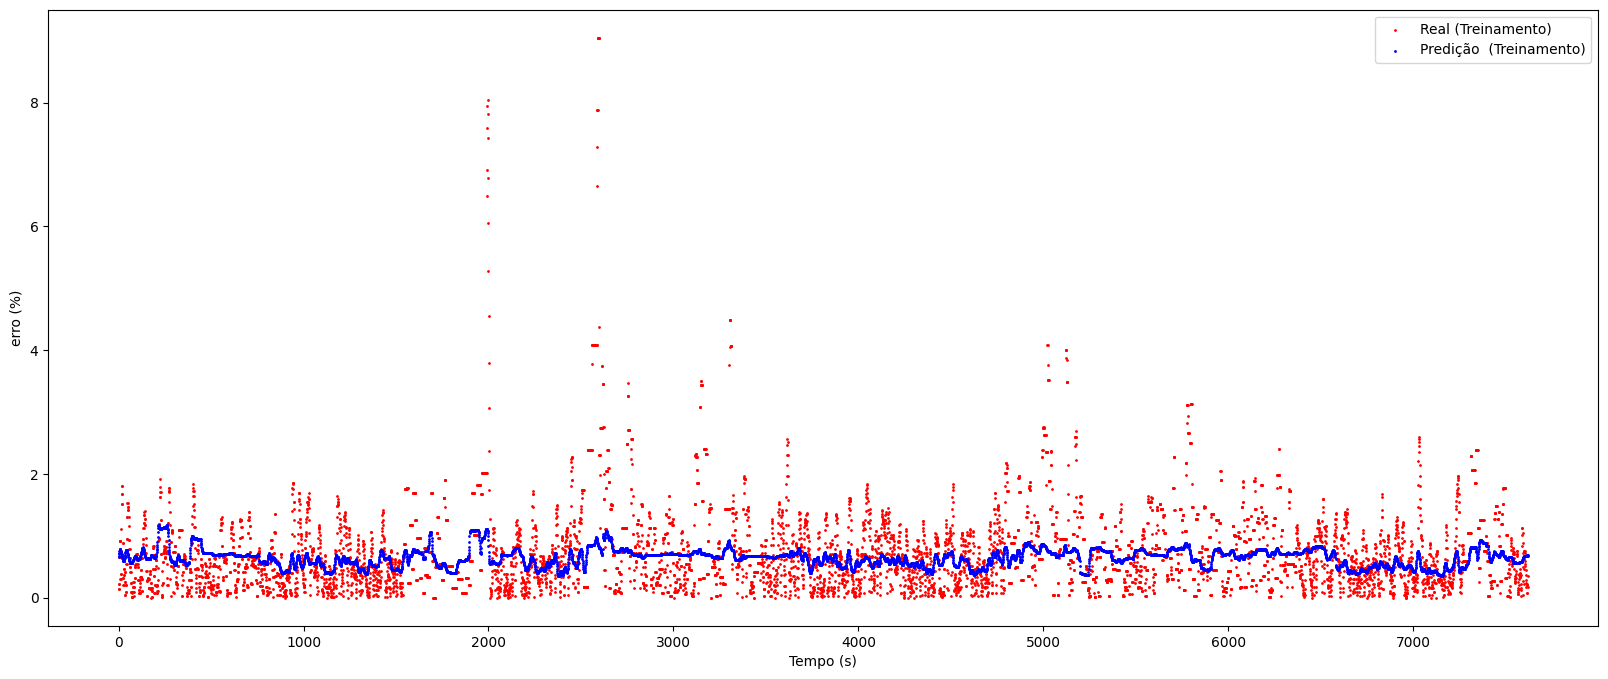

In [52]:
##Modelo 6

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train6[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

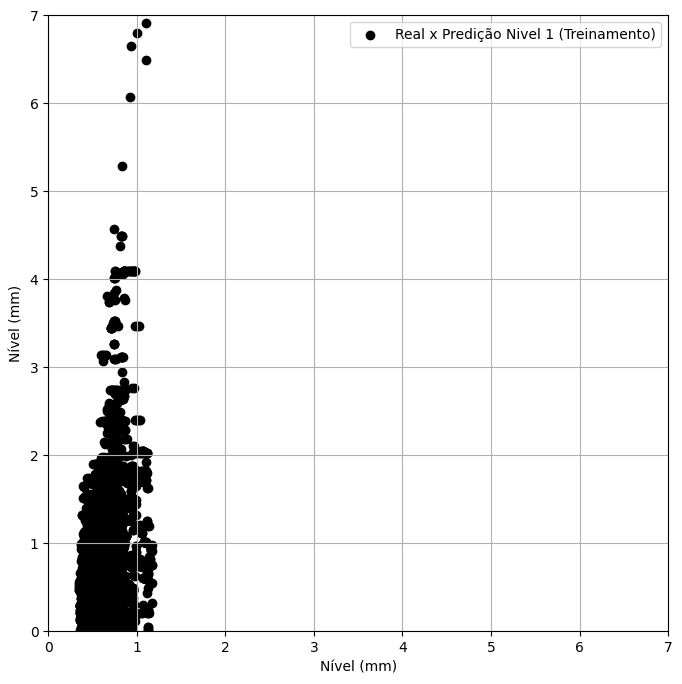

In [53]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

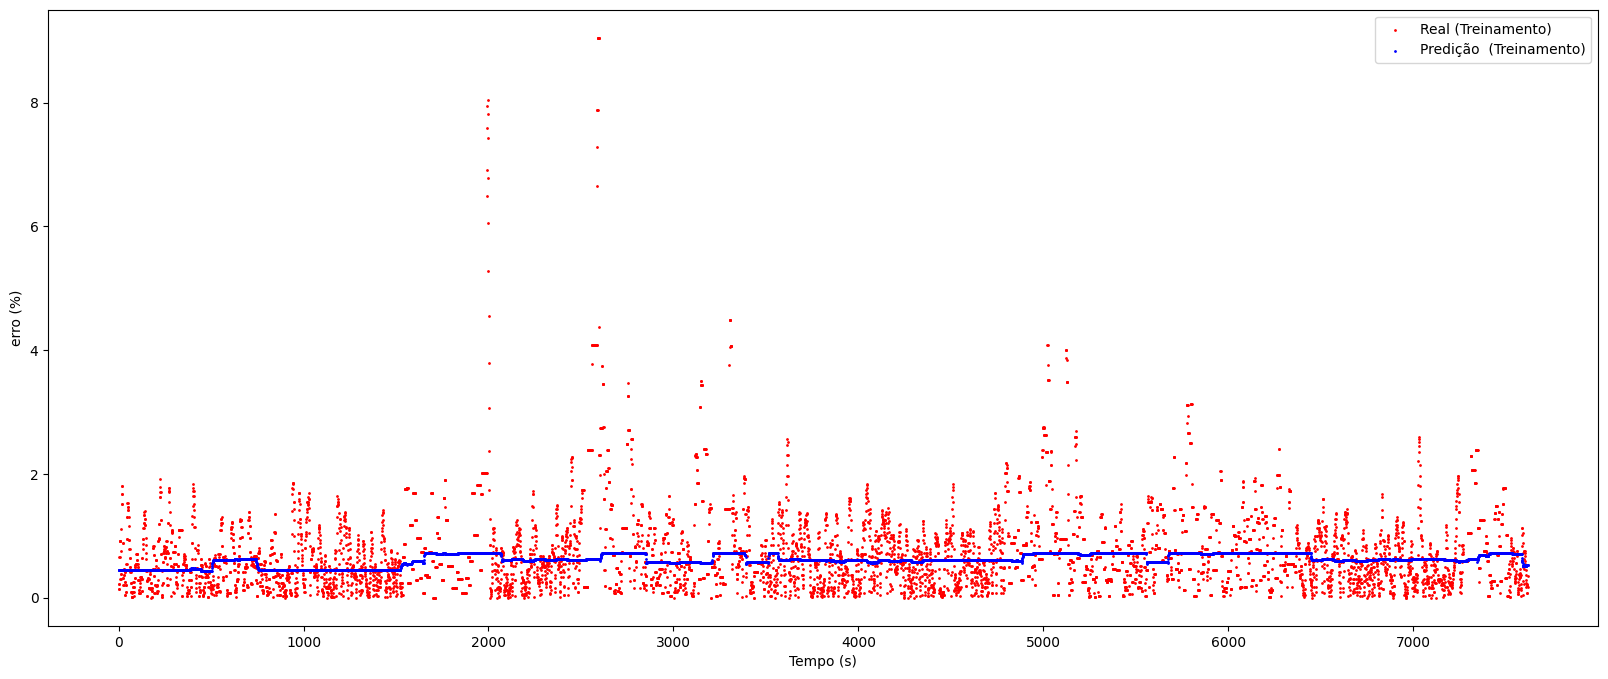

In [54]:
##Modelo 7

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train7[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

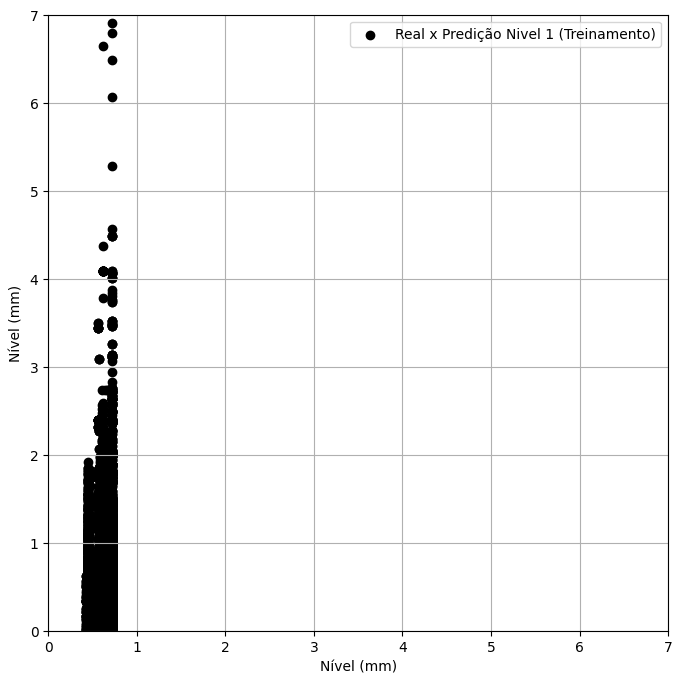

In [55]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

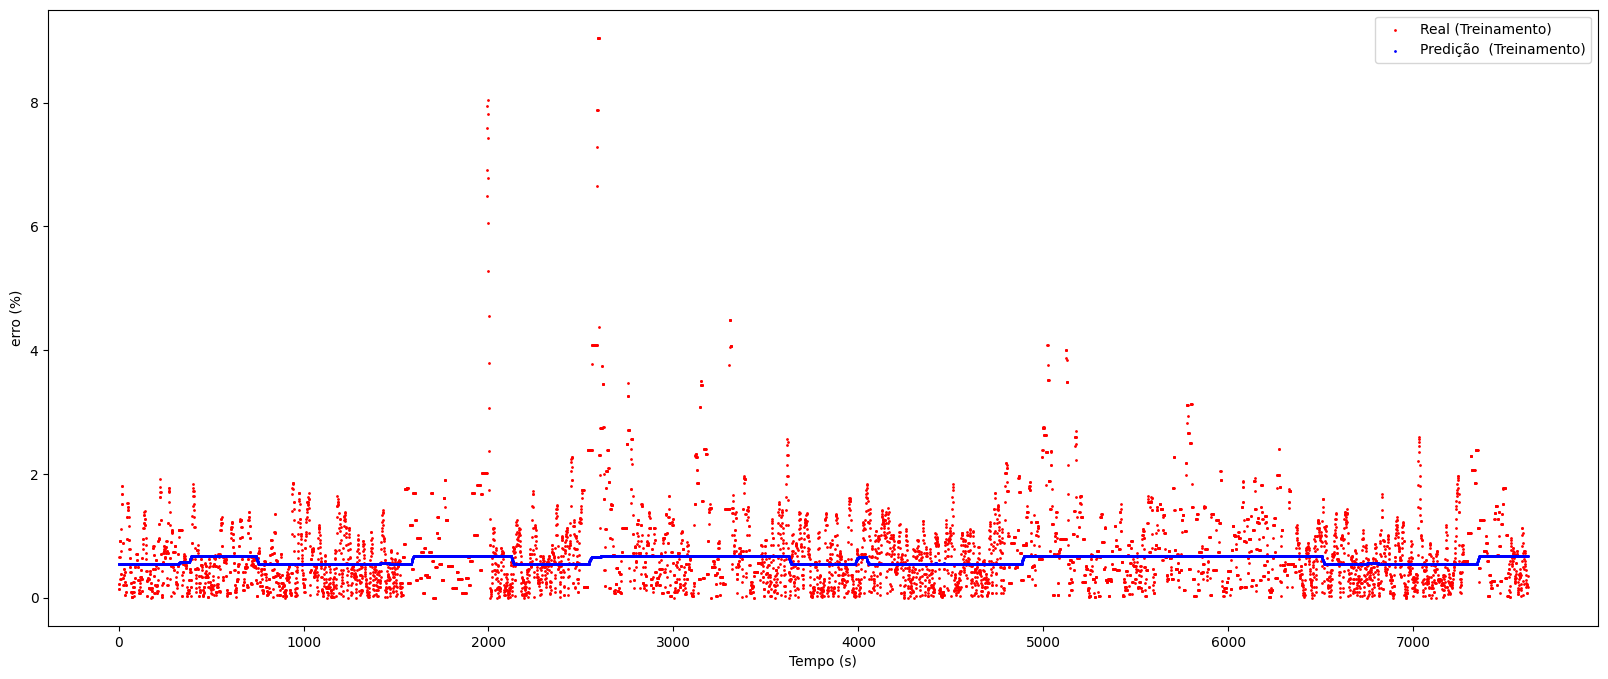

In [56]:
##Modelo 8

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train8[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

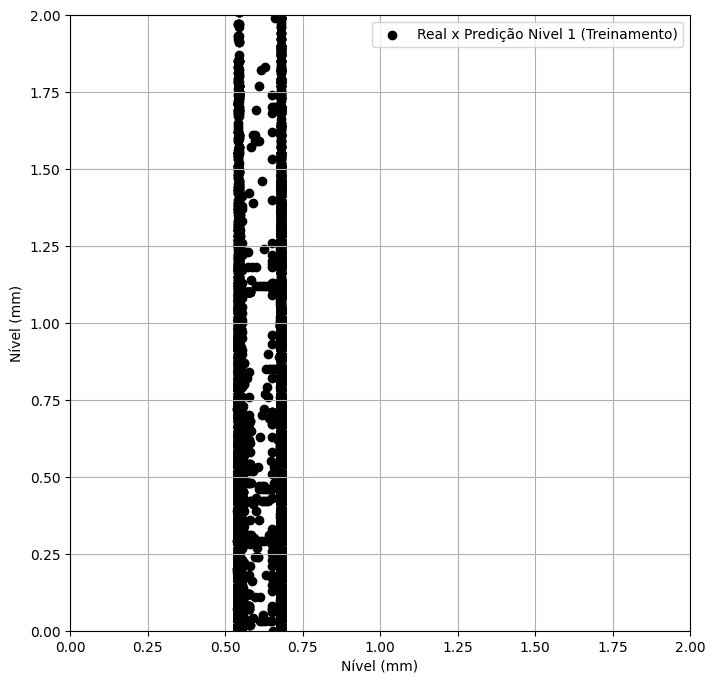

In [57]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 2, 0, 2])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

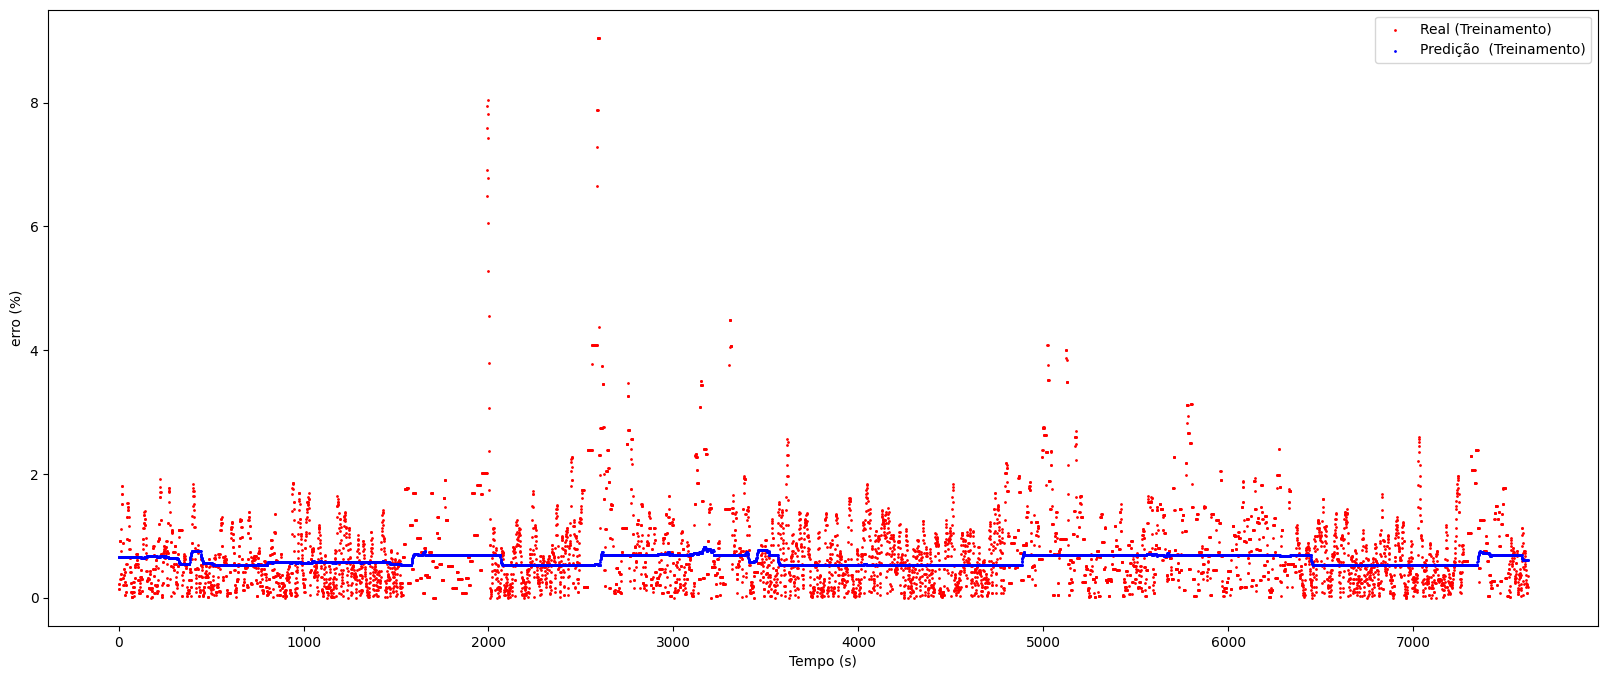

In [58]:
##Modelo 8

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train9[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

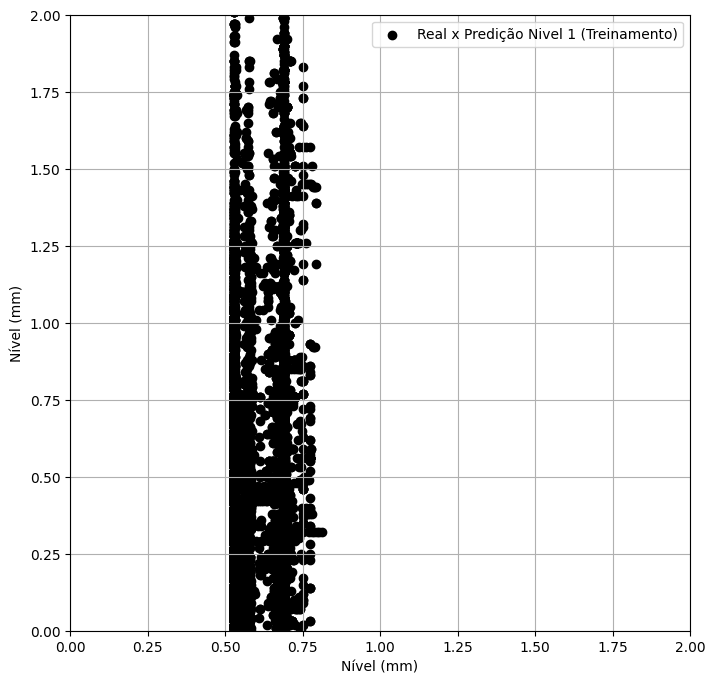

In [59]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 2, 0, 2])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

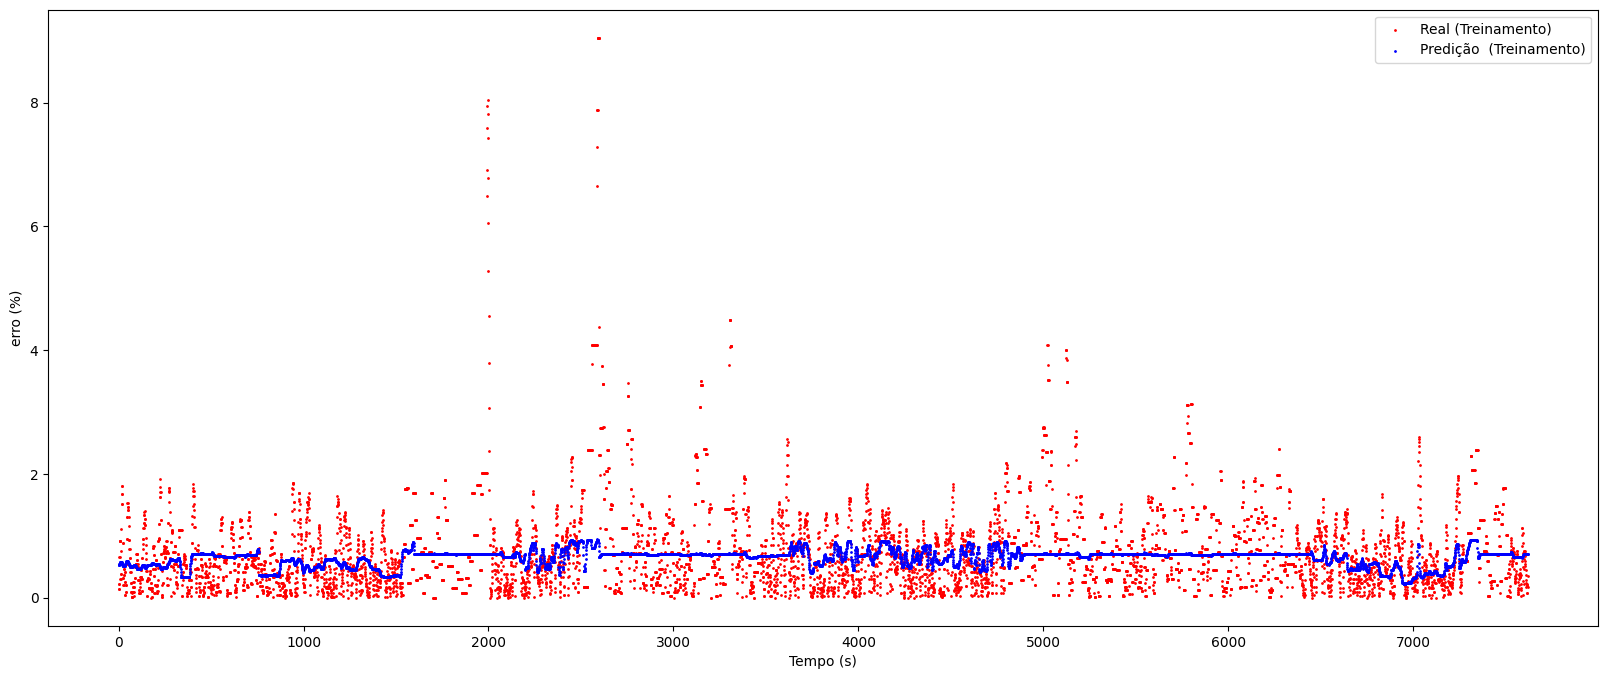

In [60]:
##Modelo 8

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_train.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train10[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_train[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)') 

Text(0, 0.5, 'Nível (mm)')

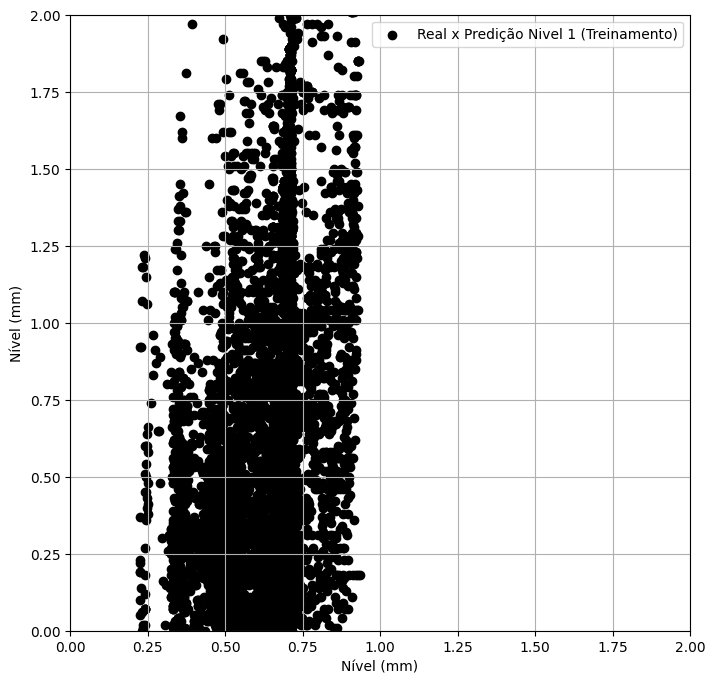

In [61]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 2, 0, 2])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

##Comportamento dos modelos com dados de testes

In [ ]:

target_train1 = modelos1.predict(X_test)
target_train2 = modelos2.predict(X_test)
target_train3 = modelos3.predict(X_test)
target_train4 = modelos4.predict(X_test)
target_train5 = modelos5.predict(X_test)
target_train6 = modelos6.predict(X_test)
target_train7 = modelos7.predict(X_test)
target_train8 = modelos8.predict(X_test)



mse_Func = tf.keras.losses.MeanSquaredError()
rmse_func = tf.keras.metrics.RootMeanSquaredError()
mae_func = tf.keras.losses.MeanAbsoluteError()

mae  =  mae_func(y_test[:,0], target_train1[:,0]).numpy()
mse  =  mse_Func(y_test[:,0], target_train1[:,0]).numpy()
rmse =  rmse_func(y_test[:,0], target_train1[:,0]).numpy()


print('Modelo 1 MAE ' + str(mae))
print('modelo 1 MSE ' + str(mse))
print('Modelo 1 RMSE ' + str(rmse))

print('['+'='*30+']')
'''
mae  =  mae_func(y_train[:,0], target_train2[:,0]).numpy()
mse = mse_Func(y_train[:,0], target_train2[:,0]).numpy()
rmse = rmse_func(y_train[:,0], target_train2[:,0]).numpy()

print('Modelo 2 MAE ' + str(mae))
print('modelo 2 MSE ' + str(mse))
print('Modelo 2 RMSE ' + str(rmse))
print('['+'='*30+']')
'''
mae  =  mae_func(y_test[:,0], target_train3[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train3[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train3[:,0]).numpy()

print('Modelo 3 MAE ' + str(mae))
print('modelo 3 MSE ' + str(mse))
print('Modelo 3 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_test[:,0], target_train4[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train4[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train4[:,0]).numpy()

print('Modelo 4 MAE ' + str(mae))
print('modelo 4 MSE ' + str(mse))
print('Modelo 4 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_test[:,0], target_train5[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train5[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train5[:,0]).numpy()

print('Modelo 5 MAE ' + str(mae))
print('modelo 5 MSE ' + str(mse))
print('Modelo 5 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_test[:,0], target_train6[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train6[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train6[:,0]).numpy()

print('Modelo 6 MAE ' + str(mae))
print('modelo 6 MSE ' + str(mse))
print('Modelo 6 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_test[:,0], target_train7[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train7[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train7[:,0]).numpy()

print('Modelo 7 MAE ' + str(mae))
print('modelo 7 MSE ' + str(mse))
print('Modelo 7 RMSE ' + str(rmse))
print('['+'='*30+']')

mae  =  mae_func(y_test[:,0], target_train8[:,0]).numpy()
mse = mse_Func(y_test[:,0], target_train8[:,0]).numpy()
rmse = rmse_func(y_test[:,0], target_train8[:,0]).numpy()

print('Modelo 8 MAE ' + str(mae))
print('modelo 8 MSE ' + str(mse))
print('Modelo 8 RMSE ' + str(rmse))
print('['+'='*30+']')





111/111 [==============================] - 1s 5ms/step
Modelo 1 MAE 0.56572294
modelo 1 MSE 1.7317653
Modelo 1 RMSE 1.311024
[==============================]
Modelo 3 MAE 0.57214093
modelo 3 MSE 1.6817164
Modelo 3 RMSE 1.2908552
[==============================]
Modelo 4 MAE 0.59093124
modelo 4 MSE 1.6597121
Modelo 4 RMSE 1.2810487
[==============================]
Modelo 5 MAE 0.67483294
modelo 5 MSE 1.8367821
Modelo 5 RMSE 1.2369546
[==============================]
Modelo 6 MAE 0.8013831
modelo 6 MSE 2.2350929
Modelo 6 RMSE 1.1758717
[==============================]
Modelo 7 MAE 0.6434147
modelo 7 MSE 1.8228767
Modelo 7 RMSE 1.1662273
[==============================]
Modelo 8 MAE 0.7852667
modelo 8 MSE 2.3147573
Modelo 8 RMSE 1.1091703
[==============================]


Text(0, 0.5, 'erro (%)')

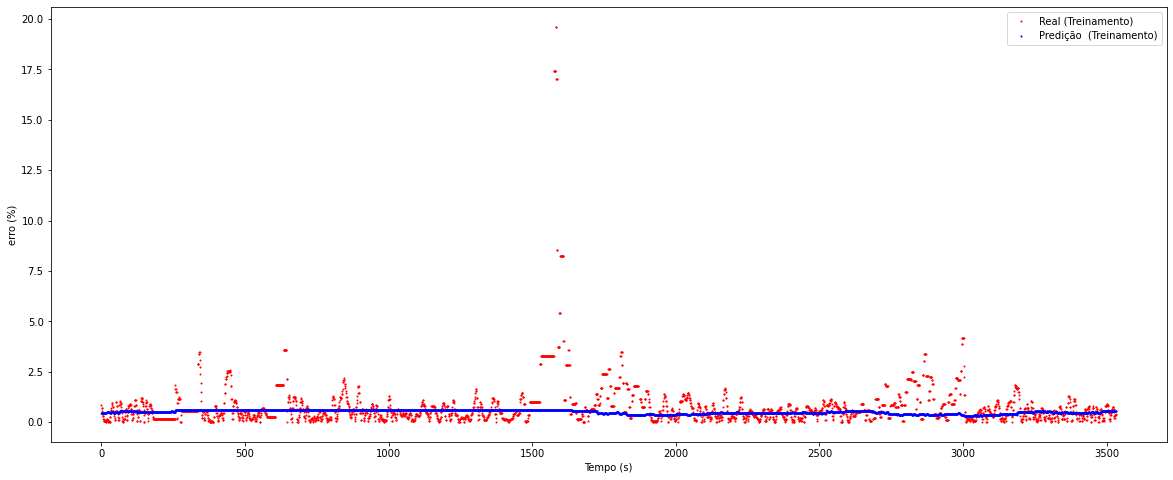

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train1[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

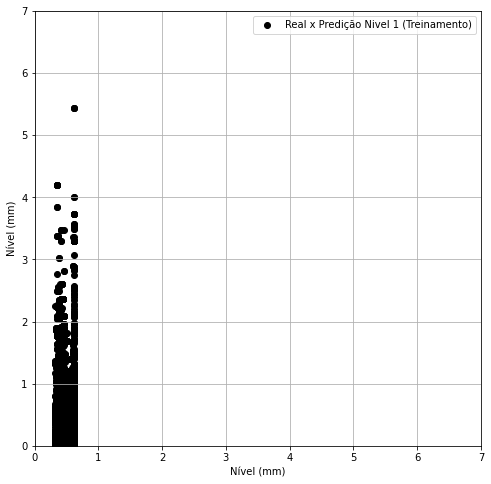

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

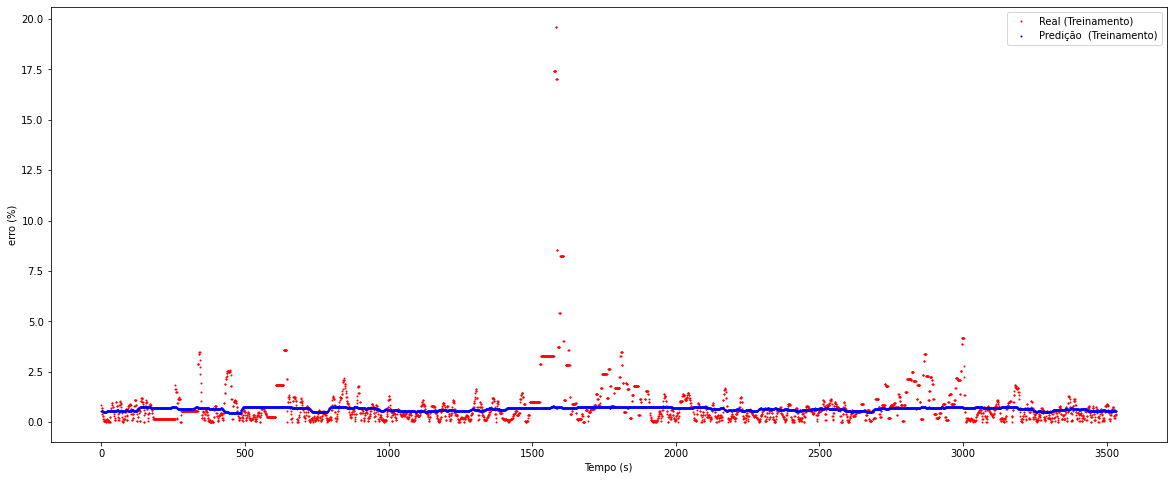

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train2[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

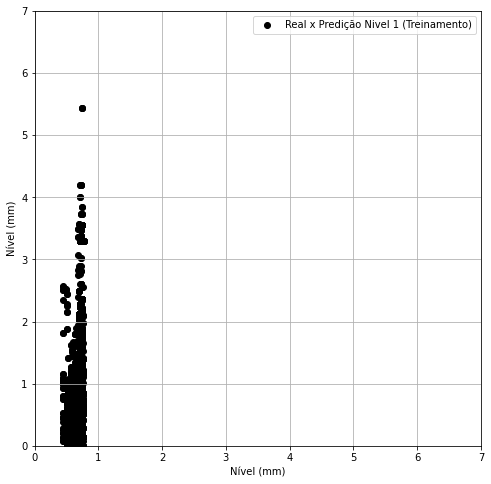

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

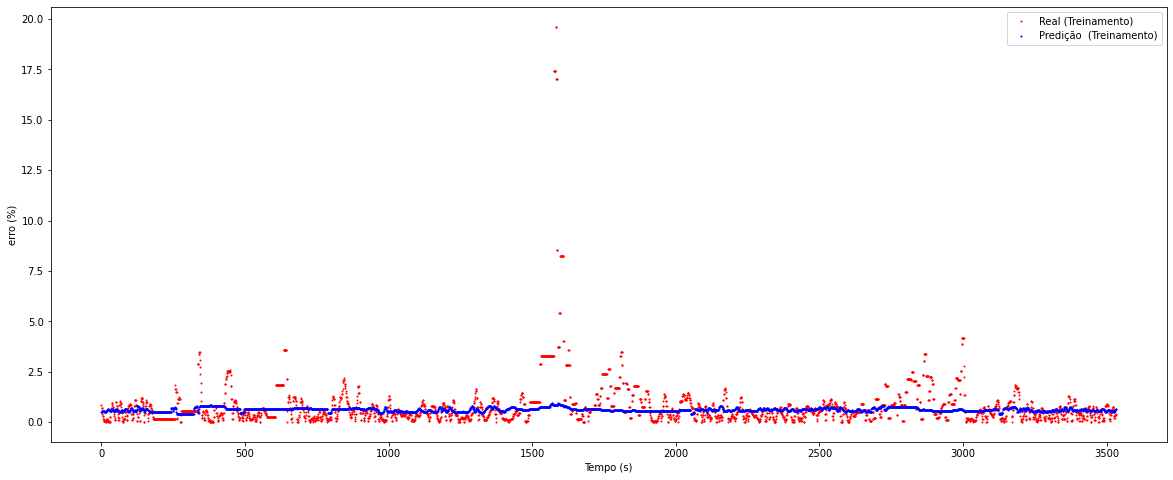

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train3[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

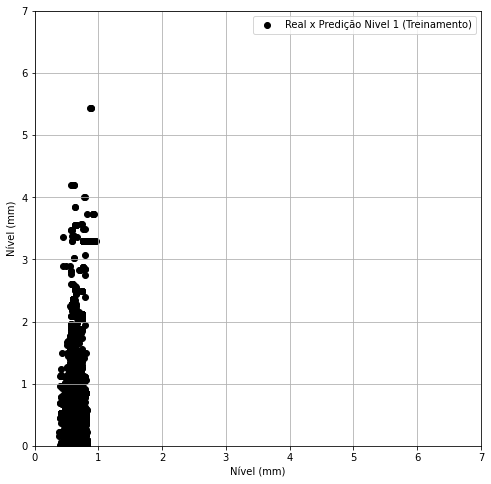

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

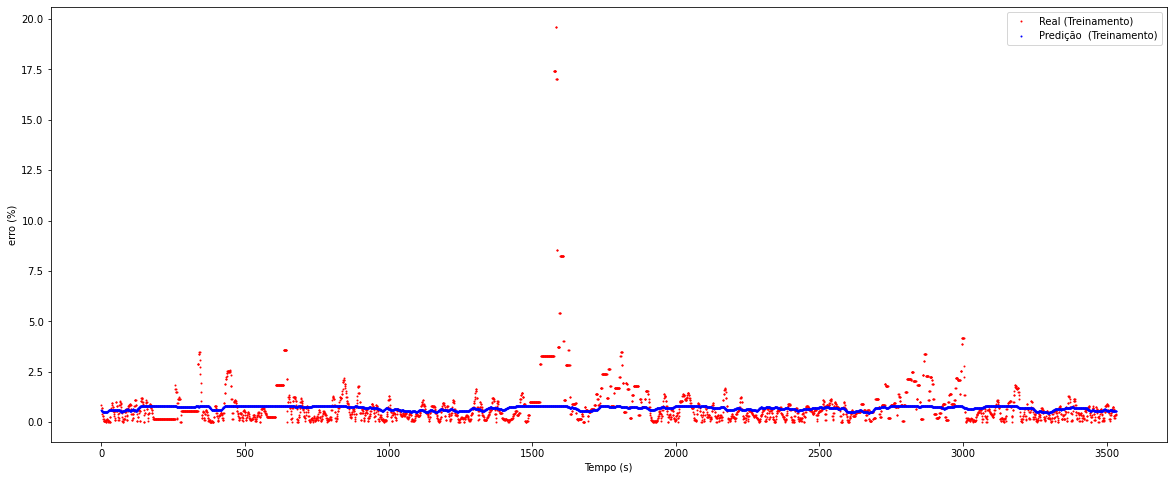

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train4[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

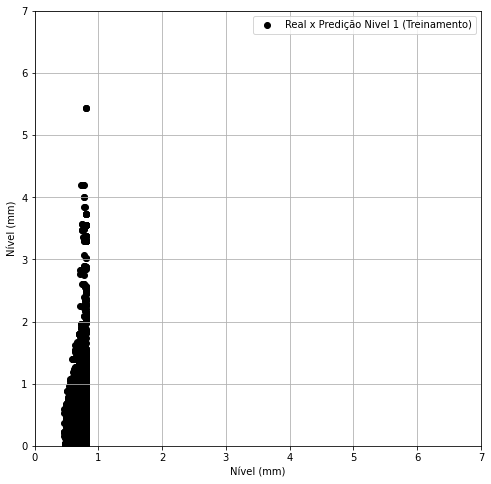

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

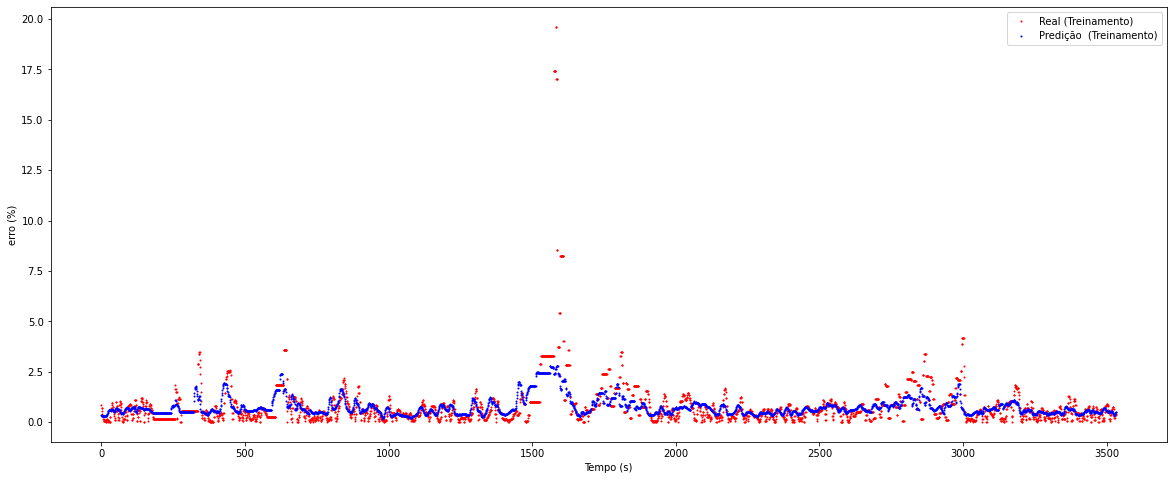

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train5[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

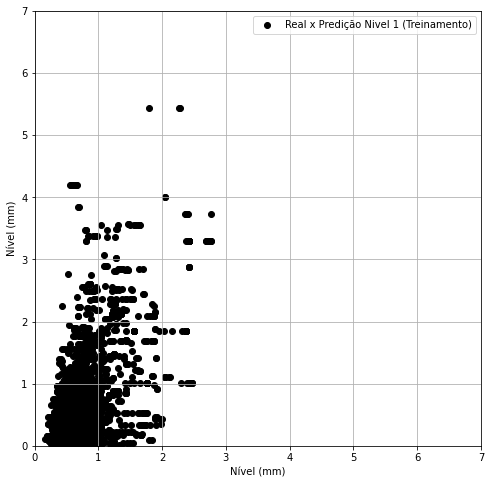

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

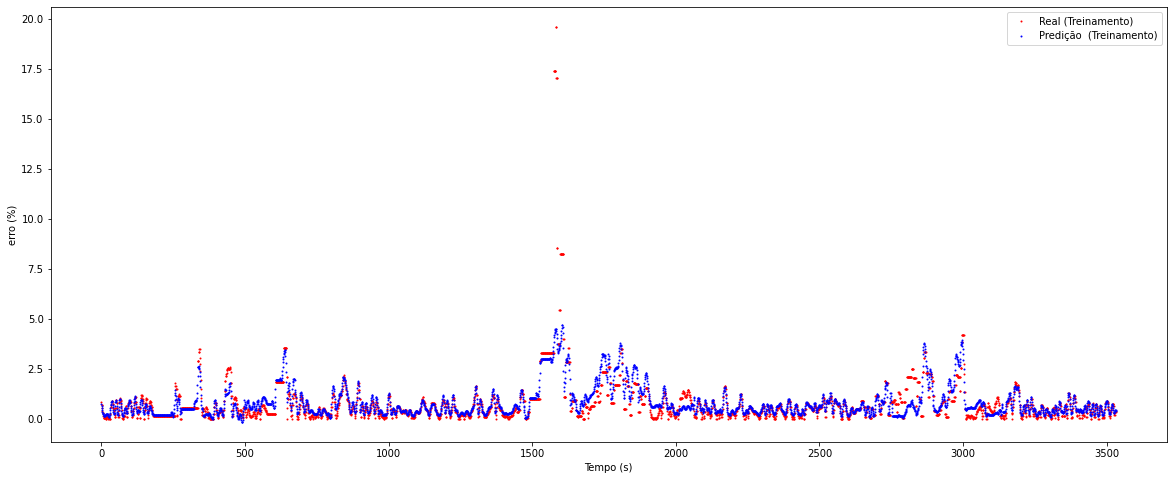

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train6[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

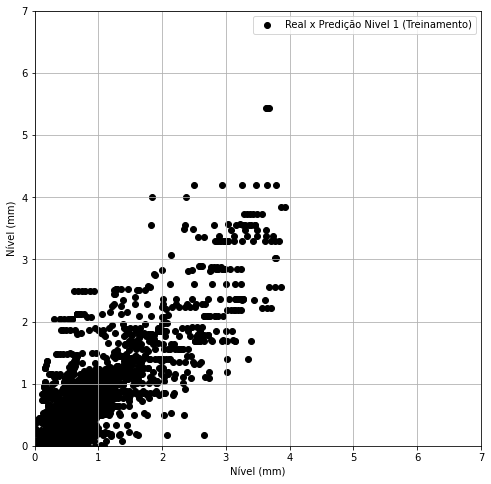

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

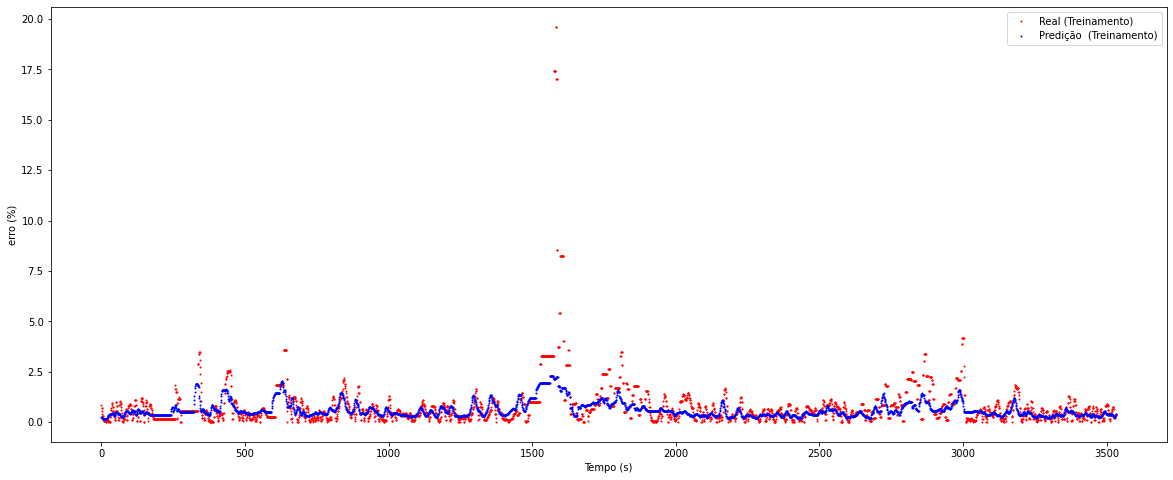

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train7[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

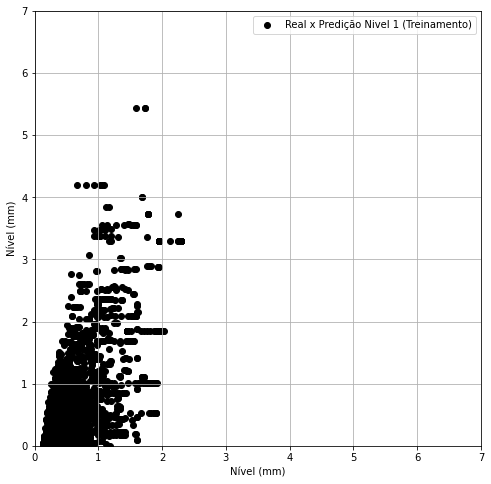

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

Text(0, 0.5, 'erro (%)')

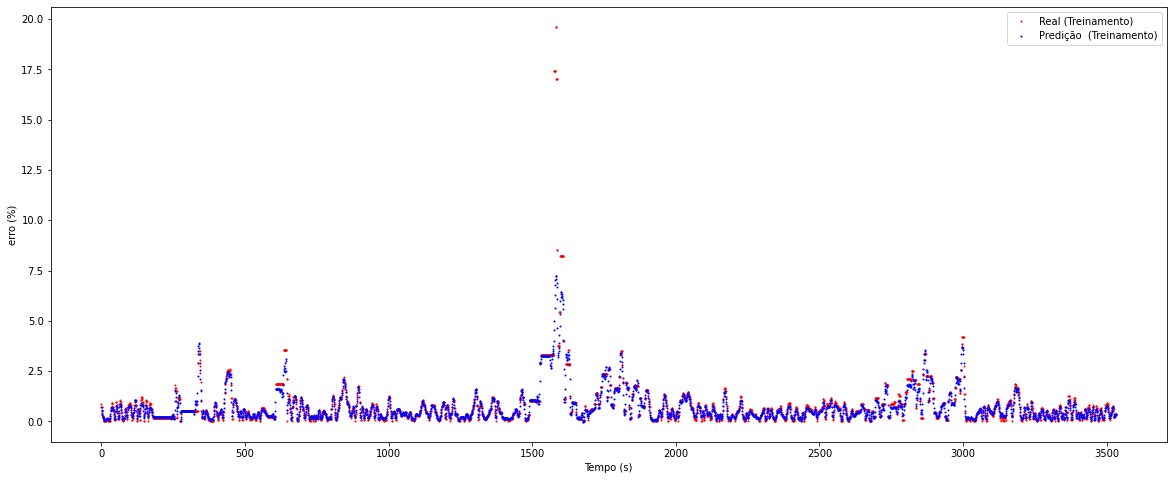

In [ ]:
##Modelo 1

# Plota os resultados
# Separa os dados que serão usados em todos os gráficos do treinamento
start = 0                                                                       # inicio do eixo x gráfico
stoptr = X_test.shape[0]                                                       # fim do eixo x gráfico
xtr =  np.arange(start, stoptr, step=1)                                         # gera o vetor temporal (amostras)
y1_1 = target_train8[:,0]                                                       # obtem os dados da predição do treinamento da rede para o nível 1
y2 = y_test[:,0]                                                               # obtem os dados reais do treinamento da rede para o nível 1

plt.figure(figsize=(20,8))                                                       
plt.scatter(xtr, y2, color = 'r', s= 1, label='Real (Treinamento)')                      # plota os dados reais com usa legenda
plt.scatter(xtr, y1_1, color = 'b', s= 1, label='Predição  (Treinamento)')                  # plota a predição com a sua legenda
plt.legend()                                                                    # plota a legenda
plt.xlabel('Tempo (s)')                                                         # plota o texto e a unidade do eixo x
plt.ylabel('erro (%)')  

Text(0, 0.5, 'Nível (mm)')

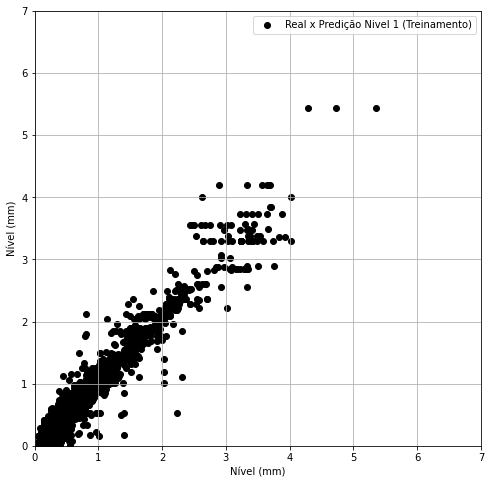

In [ ]:
plt.figure(figsize=(8,8))                                                       # dimensiona o gráfico para uma figura de 8 x 8
plt.scatter(y1_1, y2, c='k', label='Real x Predição Nivel 1 (Treinamento)')       # plota o real x predição com sua legenda
plt.axis([0, 7, 0, 7])
plt.grid()                                                                      # adicionando grid ao plot
plt.legend()                                                                    # plota a legenda
plt.xlabel('Nível (mm)')                                                        # plota o texto e a unidade do eixo x
plt.ylabel('Nível (mm)')

##Separador